<a href="https://colab.research.google.com/github/prinzessin98/ProxyDetection/blob/main/ProxyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils.extmath import randomized_svd
from scipy.linalg import null_space
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
########## Which dataset
# 0 = Adult
# 1 = Folktables
# 2 = Toy datset comp proxies
#####################
dataset = 1
#####################
if dataset == 0:
  sens_attr = 'marital-status'
  target='income'
  name='adult'
elif dataset==1:
  target = 'income'
  sens_attr = 'sex'
  name='folktables'
elif dataset==2:
  sens_attr='sensitive_attribute'
  target='target'
  name='synthetic'

# Toy dataset compositional proxies

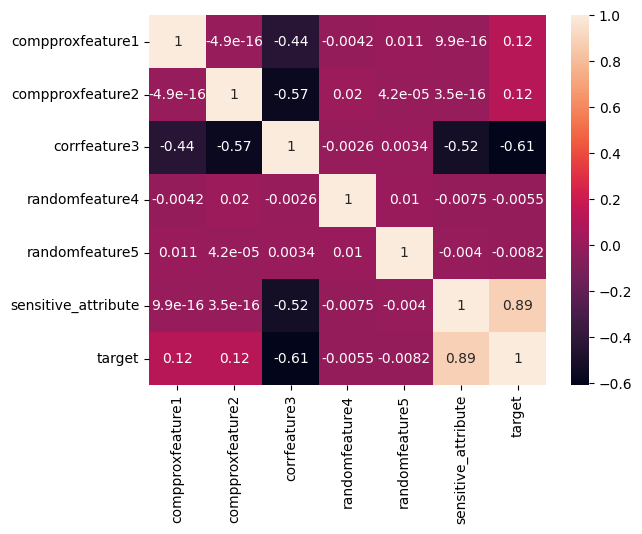

In [ ]:
if dataset==2:
  target_var = np.concatenate((np.zeros(5600), np.ones(4400)))
  sensattr = np.concatenate((np.zeros(5000), np.ones(5000)))
  feature1=np.concatenate((np.zeros(2500), np.ones(2500),np.zeros(2500), np.ones(2500)))
  feature2=np.concatenate((np.ones(2500), np.zeros(2500),np.zeros(2500),np.ones(2500)))
  feature5=np.random.randint(1,101,10000)
  feature4=np.random.randint(1000,20001,10000)
  feature3=np.concatenate((np.zeros(300),np.ones(7000),np.zeros(2700)))

  df = pd.DataFrame({'compproxfeature1':feature1, 'compproxfeature2':feature2, 'corrfeature3':feature3, 'randomfeature4':feature4, 'randomfeature5':feature5,
                     'sensitive_attribute':sensattr,
                     'target':target_var})
  corr_matrix = df.corr()
  sns.heatmap(corr_matrix, annot=True)
  plt.show()

# Dataset Folktables download & preparation


In [ ]:
if dataset == 1:
  %pip install folktables
  # load data manually from https://www2.census.gov/programs-surveys/acs/data/pums/2014/1-Year/ if not working
  # file name: csv_ptx
  from folktables import ACSDataSource, ACSIncome

  #Load the dataset
  data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
  ca_data = data_source.get_data(states=["TX"], download=False)
  features, label, _ = ACSIncome.df_to_pandas(ca_data)

  features = features.rename(columns={
      'AGEP': 'age',
      'COW': 'workclass',
      'SCHL': 'education',
      'MAR': 'marital-status',
      'OCCP': 'occupation',
      'RAC1P': 'race',
      'SEX': 'sex',
      'WKHP': 'hours-per-week'
  })
  f = features[['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex','age', 'hours-per-week']]



  # Target variable
  f['income'] = label
  df=f
  df['sex']=df['sex'].astype(int)
  df.head()

<ipython-input-10-87d3bb48e515>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['income'] = label
<ipython-input-10-87d3bb48e515>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex']=df['sex'].astype(int)


In [ ]:
if dataset==1:
  marital_status_map = {
      1:"Married ",
      2:"Widowed",
      3:"Divorced",
      4:"Separated",
      5:"Never Married or Under 15"
  }
  df['marital-status'] = df['marital-status'].replace(marital_status_map)


<ipython-input-11-d038a829648a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['marital-status'] = df['marital-status'].replace(marital_status_map)


# Adult dataset download and preparation

In [ ]:

# Load dataset
if dataset == 0:
  url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
  column_names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
      "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
      "hours-per-week", "native-country", "income"]

  df = pd.read_csv(url, header=None, names=column_names, na_values='?', skipinitialspace=True)
  print(df.shape)

(32561, 15)


In [ ]:
if dataset==0:
  marital_status_labels = {
      'Married-civ-spouse': 'Married (Civilian Spouse)',
      'Married-AF-spouse': 'Married (Armed Forces Spouse)',
      'Married-spouse-absent': 'Married (Spouse Absent)',
      'Widowed': 'Widowed',
      'Divorced': 'Divorced',
      'Separated': 'Separated',
      'Never-married': 'Never Married'
  }

  relationship_labels = {
      'Husband': 'Husband',
      'Wife': 'Wife',
      'Own-child': 'Own Child',
      'Not-in-family': 'Not in Family',
      'Other-relative': 'Other Relative',
      'Unmarried': 'Unmarried'
  }

  df['marital-status'] = df['marital-status'].map(marital_status_labels)
  df['relationship'] = df['relationship'].map(relationship_labels)


# Data depiction and preprocessing

In [ ]:
df.dropna(inplace=True)

################introduce random subsample for testing purposees
df=df.sample(n=10000, random_state=42)
#################

<ipython-input-12-3f26b041b438>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
column_names = df.columns
print("Features:\n", column_names)

Features:
 Index(['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex',
       'age', 'hours-per-week', 'income'],
      dtype='object')


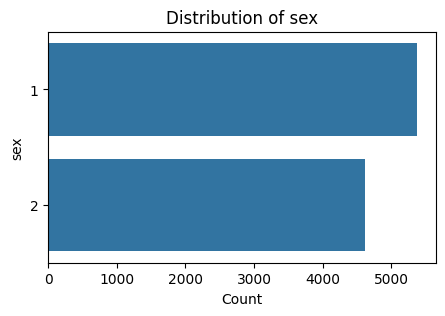

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(y=sens_attr, data=df, order=df[sens_attr].value_counts().index)
plt.title(f'Distribution of {sens_attr}')
plt.xlabel('Count')
plt.ylabel(sens_attr)
plt.show()


[[  74   45]
 [   0    1]
 [   2    3]
 [  12    8]
 [  15   13]
 [  19    4]
 [  18    9]
 [ 110   43]
 [  25   20]
 [  57   29]
 [  97   53]
 [  89   92]
 [ 156  136]
 [  98   77]
 [1104  823]
 [ 219  163]
 [ 352  382]
 [ 935  832]
 [ 351  368]
 [1009 1026]
 [ 408  372]
 [ 147   67]
 [  81   56]]


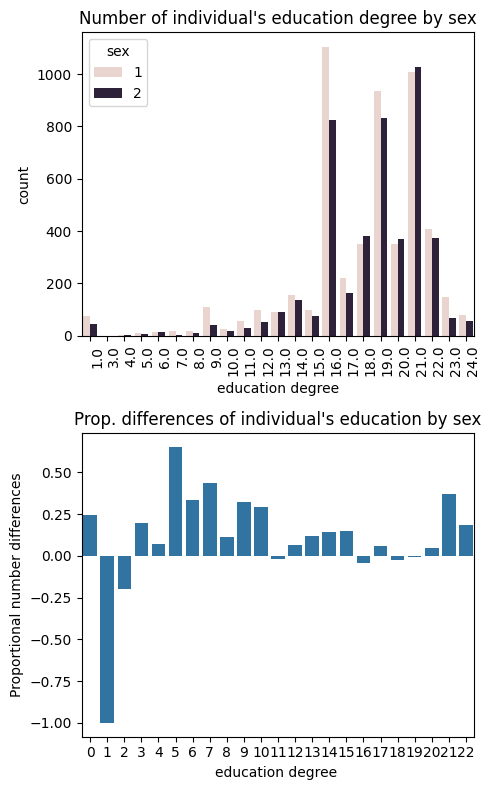

In [ ]:
if dataset==1:
  ct=pd.crosstab(df[sens_attr],df['education'])
  ct=np.array(ct)
  print(ct.T)
  fig, ax = plt.subplots(2,1, figsize=(5,8))
  sns.countplot(df, x='education', hue=sens_attr,ax=ax[0])
  ax[0].set_xlabel('education degree')
  plt.setp(ax[0].get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")
  ax[0].set_title('Number of individual\'s education degree by sex')

  sns.barplot((ct.T[:,0]-ct.T[:,1])/(ct.T[:,0]+ct.T[:,1]),ax=ax[1])
  ax[1].set_title('Prop. differences of individual\'s education by sex')
  ax[1].set_xlabel('education degree ')
  ax[1].set_ylabel('Proportional number differences')
  plt.tight_layout()
  plt.savefig('edu_sex.png')
  plt.show()


In [ ]:
if dataset==0:
  # Crosstab between marital status and income
  marital_income = pd.crosstab(df['marital-status'], df['income'])
  print(marital_income,"\n")
  marital_sex = pd.crosstab(df['marital-status'], df['sex'])
  print(marital_sex)
  sumf = int(len(df['sex'])) - int(len(df['sex'][df['sex']=='Male']))
  # Plot the distribution of marital status by income
  plt.figure(figsize=(10, 6))
  sns.countplot(x='marital-status', hue='relationship', data=df)
  plt.xticks(rotation=45)
  plt.title('Marital Status Distribution by relationship')
  plt.show()

In [ ]:
ndf=df.copy()
if dataset != 2:
  # Convert categorical variables to numerical using Label Encoding
  categorical_columns = df.select_dtypes(include=['object']).columns
  label_encoders = {}

  for col in categorical_columns:
      le = LabelEncoder()
      ndf[col] = le.fit_transform(df[col])
      label_encoders[col] = le
      print(le.classes_)

  #make marital-stauts binary
  ndf.loc[((0 < ndf["marital-status"]) & (ndf["marital-status"]<= 3)), "marital-status"]=1
  ndf.loc[ndf["marital-status"] >3, "marital-status"]=0


#ordering relationship status approrpiately
if dataset==0:
  sns.countplot(ndf, x='relationship', hue='marital-status')
  plt.show()

  counts=np.zeros(6)
  for i in range(6):
    counts[i]=ndf["marital-status"][ndf["relationship"]==i].sum()
  print(counts)
  counts_ind = np.argsort(counts)
  print(counts_ind)
  for i in range(6):
    ndf.loc[ndf["relationship"]==counts_ind[i], ['relationship']]=i-6
  ndf['relationship']=ndf['relationship']+6

  sns.countplot(ndf, x='relationship', hue='marital-status')
  plt.show()

#Creating data splits from data frame
X=ndf.drop(target, axis=1)
y=ndf[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns


['Divorced' 'Married ' 'Never Married or Under 15' 'Separated' 'Widowed']


In [ ]:
# Stroing feature names of X_train for convenience
attributes= np.array(column_names)
#['workclass', 'education', 'marital-status', 'occupation', 'race', 'sex','age', 'hours-per-week','income']
attributes= np.array(column_names)
attributes=attributes[attributes!=sens_attr]
attributes=attributes[attributes!=target]


In [ ]:
if dataset==0:
  # Plot distribution of marital status
  plt.figure(figsize=(5, 3))
  sns.countplot(y='marital-status', data=ndf, order=ndf['marital-status'].value_counts().index)
  plt.title('Distribution of Marital Status')
  plt.xlabel('Count')
  plt.yticks([0,1,2],['Married','Not Married',''])
  plt.ylabel('Marital Status')
  plt.show()

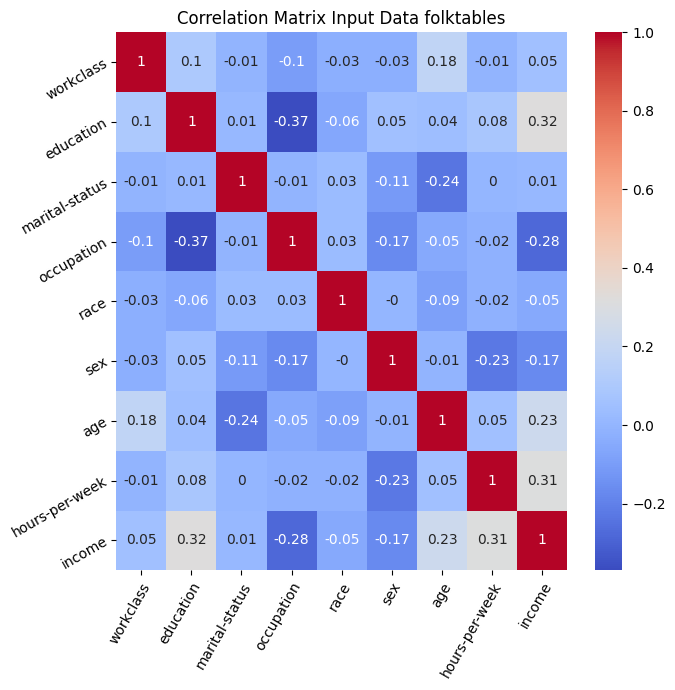

In [ ]:
# Correlation matrix
corr_matrix = round(ndf.corr(),2)
fig, ax=plt.subplots(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',ax=ax)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")
ax.set_title(f'Correlation Matrix Input Data {name}')
fig.tight_layout()
plt.savefig(f'corr_matrix_{name}.png')
plt.show()

In [ ]:
if dataset==0:
  column_names = ndf.columns
  for a in column_names[0:-1]:
    b=np.corrcoef(X_train["marital-status"], X_train[a])[0,1]
    print(f" {a} has corrcoef: {b:.3f} ")

In [ ]:
# Normalize Data
scaler = StandardScaler()
protected_attribute_train = X_train[sens_attr]
protected_attribute_test = X_test[sens_attr]
X_train = X_train.drop(sens_attr, axis=1)
X_test = X_test.drop(sens_attr, axis=1)

numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Display the first few rows of the preprocessed DataFrame
#print(X_train.head())
#print(y_train.head())

# Functions for INLP and Encoder-Decoder Model

In [ ]:
###### Build Example encoder
#### Train the model
def train_model(X, y, epochs=50, batch_size=64, val_split=0.1, latent_space=8):
# Define the neural network model for binary classification
    model = Sequential([
        Dense(latent_space*8, activation='relu', input_shape=(X.shape[1],)),
        Dropout(0.2),
        Dense(latent_space*4, activation='relu'),
        Dropout(0.2),
        Dense(latent_space*2, activation='relu'),
        Dropout(0.2),
        Dense(latent_space, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(42)
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1,
    )
    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model

def get_encoder(input, last_layer):
      return Model(inputs=input, outputs=last_layer)

#### Evaluate model
def evaluate_model(model, X, y):
    y_pred_prob = model.predict(X)
    y_pred = (y_pred_prob > 0.5).astype(int)  # get predictions

    # Calculate accuracy and print classification report
    accuracy = accuracy_score(y, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y, y_pred))



In [ ]:

def define_decoder(X):
    # Define the decoder
    # Get the encoded features for the training and test sets
    encoded_X_train = X.copy()
    input=encoded_X_train.shape[1]
    decoder_input = Input(shape=(input,))
    decoder_layer1 = Dense(input*2, activation='relu')(decoder_input)
    decoder_dropout1 = Dropout(0.2)(decoder_layer1)
    decoder_layer2 = Dense(input*4, activation='relu')(decoder_dropout1)
    decoder_dropout2 = Dropout(0.2)(decoder_layer2)
    decoder_layer3 = Dense(input*8, activation='relu')(decoder_dropout2)
    decoder_output = Dense(X_train.shape[1], activation='linear')(decoder_layer3)

    decoder = Model(decoder_input, decoder_output)

    decoder.compile(optimizer='adam', loss='mse')

    decoder.summary()
    return decoder

In [ ]:
# an abstract class for linear classifiers
# this code is imported from the paper Ravfogel et. al (2020), "Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection"
class Classifier(object):

    def __init__(self):

        pass

    def train(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:
        """

        :param X_train:
        :param Y_train:
        :param X_dev:
        :param Y_dev:
        :return: accuracy score on the dev set
        """
        raise NotImplementedError

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        raise NotImplementedError




class SKlearnClassifier(Classifier):

    def __init__(self, m):

        self.model = m

    def train_network(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:

        """
        :param X_train:
        :param Y_train:
        :param X_dev:
        :param Y_dev:
        :return: accuracy score on the dev set / Person's R in the case of regression
        """

        self.model.fit(X_train, Y_train)
        score = self.model.score(X_dev, Y_dev)
        return score

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        w = self.model.coef_
        if len(w.shape) == 1:
                w = np.expand_dims(w, 0)

        return w

In [ ]:
# this code is imported from the paper Ravfogel et. al (2020), "Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection"

from typing import Dict
import numpy as np
import scipy
from typing import List
from tqdm import tqdm
import random
import warnings


def get_rowspace_projection(W: np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    if np.allclose(W, 0):
        w_basis = np.zeros_like(W.T)
    else:
        w_basis = scipy.linalg.orth(W.T) # orthogonal basis

    P_W = w_basis.dot(w_basis.T) # orthogonal projection on W's rowspace

    return P_W

def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0)
    P = I - get_rowspace_projection(Q)

    return P

def debias_by_specific_directions(directions: List[np.ndarray], input_dim: int):
    """
    the goal of this function is to perform INLP on a set of user-provided directions (instead of learning those directions).
    :param directions: list of vectors, as numpy arrays.
    :param input_dim: dimensionality of the vectors.
    """

    rowspace_projections = []

    for v in directions:
        P_v = get_rowspace_projection(v)
        rowspace_projections.append(P_v)

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P


def get_debiasing_projection(classifier_class, cls_params: Dict, num_classifiers: int, input_dim: int,
                             is_autoregressive: bool,
                             min_accuracy: float, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray,
                             Y_dev: np.ndarray, by_class=False, Y_train_main=None,
                             Y_dev_main=None, dropout_rate = 0) -> np.ndarray:
    """
    :param classifier_class: the sklearn classifier class (SVM/Perceptron etc.)
    :param cls_params: a dictionary, containing the params for the sklearn classifier
    :param num_classifiers: number of iterations (equivalent to number of dimensions to remove)
    :param input_dim: size of input vectors
    :param is_autoregressive: whether to train the ith classiifer on the data projected to the nullsapces of w1,...,wi-1
    :param min_accuracy: above this threshold, ignore the learned classifier
    :param X_train: ndarray, training vectors
    :param Y_train: ndarray, training labels (protected attributes)
    :param X_dev: ndarray, eval vectors
    :param Y_dev: ndarray, eval labels (protected attributes)
    :param by_class: if true, at each iteration sample one main-task label, and extract the protected attribute only from vectors from this class
    :param T_train_main: ndarray, main-task train labels
    :param Y_dev_main: ndarray, main-task eval labels
    :param dropout_rate: float, default: 0 (note: not recommended to be used with autoregressive=True)
    :return: P, the debiasing projection; rowspace_projections, the list of all rowspace projection; Ws, the list of all classifiers.
    """
    if dropout_rate > 0 and is_autoregressive:
        warnings.warn("Note: when using dropout with autoregressive training, the property w_i.dot(w_(i+1)) = 0 no longer holds.")

    I = np.eye(input_dim)

    if by_class:
        if ((Y_train_main is None) or (Y_dev_main is None)):
            raise Exception("Need main-task labels for by-class training.")
        main_task_labels = list(set(Y_train_main.tolist()))

    X_train_cp = X_train.copy()
    X_dev_cp = X_dev.copy()
    rowspace_projections = []
    Ws = []

    pbar = tqdm(range(num_classifiers))
    for i in pbar:

        clf = SKlearnClassifier(classifier_class(**cls_params))
        dropout_scale = 1./(1 - dropout_rate + 1e-6)
        dropout_mask = (np.random.rand(*X_train.shape) < (1-dropout_rate)).astype(float) * dropout_scale


        if by_class:
            #cls = np.random.choice(Y_train_main)  # uncomment for frequency-based sampling
            cls = random.choice(main_task_labels)
            relevant_idx_train = Y_train_main == cls
            relevant_idx_dev = Y_dev_main == cls
        else:
            relevant_idx_train = np.ones(X_train_cp.shape[0], dtype=bool)
            relevant_idx_dev = np.ones(X_dev_cp.shape[0], dtype=bool)

        acc = clf.train_network((X_train_cp * dropout_mask)[relevant_idx_train], Y_train[relevant_idx_train], X_dev_cp[relevant_idx_dev], Y_dev[relevant_idx_dev])
        pbar.set_description("iteration: {}, accuracy: {}".format(i, acc))
        print(acc)
        if acc < min_accuracy: continue

        W = clf.get_weights()
        Ws.append(W)
        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        if is_autoregressive:

            """
            to ensure numerical stability, explicitly project to the intersection of the nullspaces found so far (instaed of doing X = P_iX,
            which is problematic when w_i is not exactly orthogonal to w_i-1,...,w1, due to e.g inexact argmin calculation).
            """
            # use the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
            # N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))

            P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
            # project

            X_train_cp = (P.dot(X_train.T)).T
            X_dev_cp = (P.dot(X_dev.T)).T

    """
    calculate final projection matrix P=PnPn-1....P2P1
    since w_i.dot(w_i-1) = 0, P2P1 = I - P1 - P2 (proof in the paper); this is more stable.
    by induction, PnPn-1....P2P1 = I - (P1+..+PN). We will use instead Ben-Israel's formula to increase stability and also generalize to the non-orthogonal case (e.g. with dropout),
    i.e., we explicitly project to intersection of all nullspaces (this is not critical at this point; I-(P1+...+PN) is roughly as accurate as this provided no dropout & regularization)
    """

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)

    return P, rowspace_projections, Ws


In [ ]:
# Train the decoder
def train_decoder(X, projected_outputs, epochs=50, batch_size=64, val_split=0.2):
    decoder=define_decoder(projected_outputs)
    decoder.compile(optimizer='adam', loss='mse')
    # Train the decoder
    history_decoder_inlp = decoder.fit(
        projected_outputs, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1
    )

    plt.plot(range(1,epochs+1),history_decoder_inlp.history['loss'], label='Training Loss')
    plt.plot(range(1,epochs+1),history_decoder_inlp.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return decoder

In [ ]:
# this code is imported from the paper Ravfogel et. al (2020), "Null It Out: Guarding Protected Attributes by Iterative Nullspace Projection"
def train_classifier(X, Z):
    """
    Train a classifier to predict the protected attributes Z from the data X.

    Args:
        X: Input data of shape (num_samples, num_features).
          -> here use the encoded features
        Z: Protected attributes of shape (num_samples, num_protected_attributes).

    Returns:
        W: The weight matrix of the trained classifier.
    """
    # Use logistic regression as the classifier
    classifier = LogisticRegression()
    classifier.fit(X,Z)
    print('accuracy of logistic classifier:', classifier.score(X,Z))
    # Return the weight matrix (coefficients) of the classifier
    return classifier.coef_.T  # Shape: (num_features, num_protected_attributes)

def iterative_nullspace_projection(X, Y, n_rounds=10):
    from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
    d = X.shape[1]
    num_classifiers = n_rounds
    classifier_class = LogisticRegression
    input_dim = d
    is_autoregressive = True
    min_accuracy = 0.0

    P, rowspace_projections, Ws = get_debiasing_projection(classifier_class, {}, num_classifiers, input_dim, is_autoregressive, min_accuracy, X, Y, X, Y, by_class = False)

    I = np.eye(P.shape[0])
    P_alternative = I - np.sum(rowspace_projections, axis = 0)
    P_by_product = I.copy()

    for P_Rwi in rowspace_projections:

        P_Nwi = I - P_Rwi
        P_by_product = P_Nwi.dot(P_by_product)


    #testing

    # validate that P = PnPn-1...P2P1 (should be true only when w_i.dot(w_(i+1)) = 0, in autoregressive training)

    if is_autoregressive:
        assert np.allclose(P_alternative, P)
        assert np.allclose(P_by_product, P)

    # validate that P is a projection

    assert np.allclose(P.dot(P), P)

    # validate that P projects to N(w1)∩ N(w2) ∩ ... ∩ N(wn)

    x = np.random.rand(d) - 0.5
    for w in Ws:

        assert np.allclose(np.linalg.norm(w.dot(P.dot(x))), 0.0)

    # validate that each two classifiers are orthogonal (this is expected to be true only with autoregressive training)

    if is_autoregressive:
        for i,w in enumerate(Ws):

            for j, w2 in enumerate(Ws):

                if i == j: continue

                assert np.allclose(np.linalg.norm(w.dot(w2.T)), 0)

    return P



In [ ]:
def get_inlp(encoder_outputs, protected_attribute, n_rounds):
    # Perform INLP
    P = iterative_nullspace_projection(encoder_outputs, protected_attribute, n_rounds=n_rounds)
    return P

In [ ]:
# extract last layer/input
def get_encoder_output(model):
    return model.layers[-2].output
def get_encoder_input(model):
    return model.layers[0].input


# Test Pipeline INLP Enc-Dec Model

In [ ]:
########### Necessary Data input
only_inlp_change=False
if only_inlp_change ==  False:
  X_train= X_train
  y_train = y_train
  X_test= X_test
  y_test = y_test
  protected_attribute_test = protected_attribute_test
  protected_attribute_train = protected_attribute_train
###########


In [ ]:
############# Hyperparameter INLP
num_iterations = 5
latent_space= 8
#############

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_107 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7268 - loss: 0.5840 - val_accuracy: 0.8288 - val_loss: 0.3651
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8091 - loss: 0.3985 - val_accuracy: 0.8375 - val_loss: 0.3501
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8318 - loss: 0.3810 - val_accuracy: 0.8438 - val_loss: 0.3454
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8230 - loss: 0.3800 - val_accuracy: 0.8363 - val_loss: 0.3464
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8324 - loss: 0.3686 - val_accuracy: 0.8450 - val_loss: 0.3411
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8350 - loss: 0.3634 - val_accuracy: 0.8450 - val_loss: 0.3402
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8385 - loss: 0.3590 - val_accuracy: 0.8475 - val_loss: 0.3389
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8338 - loss: 0.3617 - val_accuracy: 0

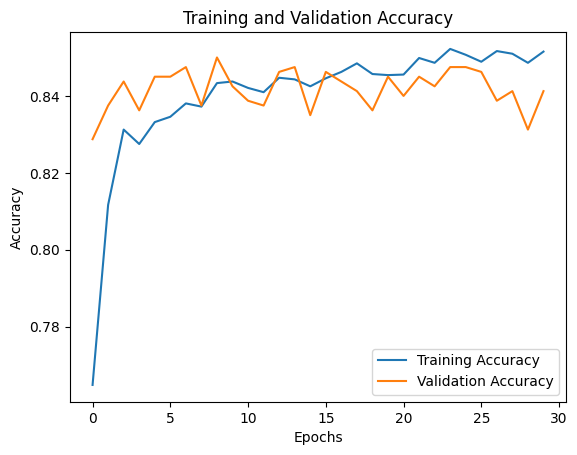

In [ ]:
### Train examined model
if only_inlp_change ==  False:
  model = train_model(X_train, y_train, epochs=30, batch_size=64, val_split=0.1, latent_space=latent_space)

In [ ]:
evaluate_model(model, X_test,y_test)

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.8280

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1512
           1       0.69      0.53      0.60       488

    accuracy                           0.83      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.82      0.83      0.82      2000

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[1397  115]
 [ 229  259]]


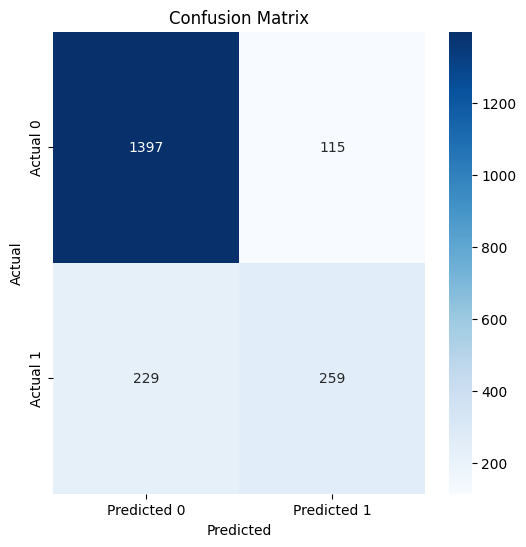

In [ ]:
# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
### Trained parameters
encoded_data = get_encoder_output(model)
encoder = get_encoder(get_encoder_input(model), encoded_data)


# Get the output of last layer as a NumPy array
encoder_outputs_train = encoder.predict(X_train)
encoder_outputs_test = encoder.predict(X_test)

# inlp projection of encoded data
inlp_matrix = get_inlp(encoder_outputs_train, protected_attribute_train, num_iterations)

# Project the data onto the null space
X_projected = (inlp_matrix @ encoder_outputs_test.T).T
X_projected_train = (inlp_matrix @ encoder_outputs_train.T).T



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


iteration: 0, accuracy: 0.853625:   0%|          | 0/5 [00:00<?, ?it/s]

0.853625


iteration: 4, accuracy: 0.82: 100%|██████████| 5/5 [00:00<00:00, 20.91it/s]

0.837125
0.824125
0.82025
0.82
Original Data Shape: (10000, 14)
Projected Data Shape: (2000, 8)
Projection Matrix Shape: (8, 8)


Testing model accuracy after cleaning the data with inlp:

In [ ]:
X_projected = (inlp_matrix @ encoder_outputs_test.T).T
X_projected_train = (inlp_matrix @ encoder_outputs_train.T).T

# Check accuracy of inp reconstruction for target
log=LogisticRegression()
log.fit(X_projected_train, y_train)
print('Accuracy of predicting y from inlp_projected X: ',log.score(X_projected, y_test))
print('majority vote result:', 1-y_test.sum()/len(y_test))

# Check if inlp reconstruction allows for predicting sens attr a
log=LogisticRegression()
log.fit(X_projected_train, protected_attribute_train)
print('Accuracy of predicting a from inlp_projected X: ', log.score(X_projected, protected_attribute_test))
print('majority vote result:', 1-protected_attribute_test.sum()/len(protected_attribute_test))

# Get the accuracy of the original datasets prediction for the sens attr
log=LogisticRegression()
log.fit(X_train, protected_attribute_train)
print('Accuracy of predicting a from X: ', log.score(X_test, protected_attribute_test))

Accuracy of predicting y from inlp_projected X:  0.826
majority vote result: 0.756
Accuracy of predicting a from inlp_projected X:  0.8205
majority vote result: 0.5145
Accuracy of predicting a from X:  0.979


How impactful are the features changed by the inlp matrix:

In [ ]:
print("The weights sorted by the differences introduced by the cleaning process + change strength:\n",
      np.round(np.stack((np.array(model.weights[-2].value)[np.argsort(-np.mean(X_projected - encoder_outputs_test,axis=0)**2)].flatten(),-np.sort(-np.mean(X_projected - encoder_outputs_test,axis=0)**2)),axis=1),3))

The weights sorted by the differences introduced by the cleaning process + change strength:
 [[-4.570e-01  6.892e+00]
 [-6.150e-01  9.690e-01]
 [ 3.710e-01  5.770e-01]
 [ 6.460e-01  1.330e-01]
 [ 7.780e-01  1.140e-01]
 [ 7.630e-01  2.000e-03]
 [-4.310e-01  0.000e+00]
 [-9.160e-01  0.000e+00]]


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,645 (14.24 KB)

 Trainable params: 3,645 (14.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0288 - val_loss: 0.8465
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8608 - val_loss: 0.8220
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8267 - val_loss: 0.8076
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8128 - val_loss: 0.7955
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7938 - val_loss: 0.7781
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7837 - val_loss: 0.7681
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7738 - val_loss: 0.7578
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7700 - val_loss: 0.7500
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7552 - val_loss: 0.7439
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7505 - val_loss: 0.7428
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7491 - val_loss: 0.7388
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

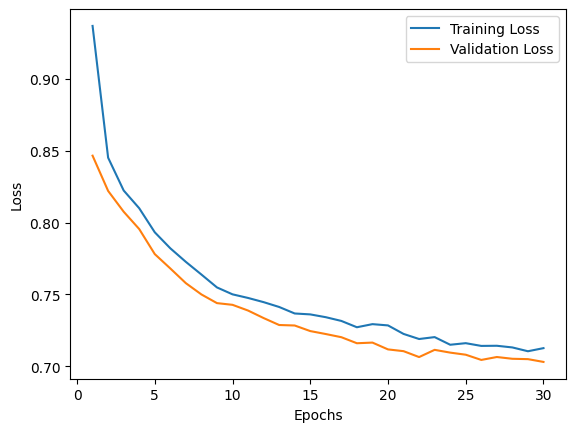

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,645 (14.24 KB)

 Trainable params: 3,645 (14.24 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,645 (14.24 KB)

 Trainable params: 3,645 (14.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.1634 - val_loss: 0.8597
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8724 - val_loss: 0.8305
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8419 - val_loss: 0.8233
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8251 - val_loss: 0.8206
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8191 - val_loss: 0.8176
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8148 - val_loss: 0.8138
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8073 - val_loss: 0.8091
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7971 - val_loss: 0.8078
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7973 - val_loss: 0.8081
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7962 - val_loss: 0.8092
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7922 - val_loss: 0.8044
Epoch 12/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

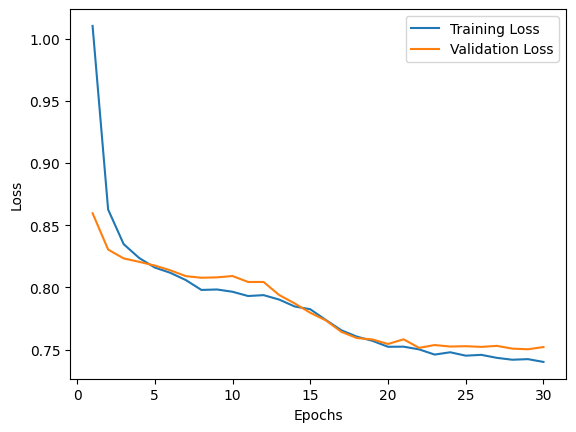

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
#### decoder
#decoder = define_decoder(encoder_outputs_train)
if False == only_inlp_change:
  decoder_trained = train_decoder(X_train, encoder_outputs_train, epochs=30)

# Reconstruct the test set

  reconstructed_X_test = decoder_trained.predict(encoder_outputs_test)


# Reconstruct the test set
reconstructed_X_test_inlp_old = decoder_trained.predict(X_projected)



In [ ]:
#original data corrrelation to pa
b=np.zeros_like(attributes)
for (a, i) in zip(attributes, range(len(attributes))):
  b[i]=abs(np.corrcoef(protected_attribute_test, X_test[a])[0,1])
  print(f" {a} has corrcoef: {float(b[i]):.3f} with a in X_test")
arg=np.argmax(b)
b=np.nan_to_num(b,nan=0)
print(f"\n max correlation is {attributes[arg]}: {float(b[arg]):.3f}")

 age has corrcoef: 0.350 with a in X_test
 workclass has corrcoef: 0.055 with a in X_test
 fnlwgt has corrcoef: 0.045 with a in X_test
 education has corrcoef: 0.033 with a in X_test
 education-num has corrcoef: 0.024 with a in X_test
 occupation has corrcoef: 0.053 with a in X_test
 relationship has corrcoef: 0.821 with a in X_test
 race has corrcoef: 0.082 with a in X_test
 sex has corrcoef: 0.448 with a in X_test
 capital-gain has corrcoef: 0.087 with a in X_test
 capital-loss has corrcoef: 0.094 with a in X_test
 hours-per-week has corrcoef: 0.194 with a in X_test
 native-country has corrcoef: 0.022 with a in X_test

 max correlation is relationship: 0.821


In [ ]:
# normal reconstruction correlation to pa
b2=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b2[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b2[i]):.3f} in X_test")
b2 = np.nan_to_num(b2,nan=0)
arg=np.argmax(b2)
print(f"\n max correlation is {attributes[arg]}: {float(b2[arg]):.3f}")

 age has corrcoef: 0.523 in X_test
 workclass has corrcoef: 0.167 in X_test
 fnlwgt has corrcoef: 0.145 in X_test
 education has corrcoef: 0.043 in X_test
 education-num has corrcoef: 0.354 in X_test
 occupation has corrcoef: 0.230 in X_test
 relationship has corrcoef: 0.728 in X_test
 race has corrcoef: 0.630 in X_test
 sex has corrcoef: 0.663 in X_test
 capital-gain has corrcoef: 0.107 in X_test
 capital-loss has corrcoef: 0.398 in X_test
 hours-per-week has corrcoef: 0.433 in X_test
 native-country has corrcoef: 0.033 in X_test

 max correlation is relationship: 0.728


In [ ]:
#inlp (same decoder) reconstruction correlation to pa
b4=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b4[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test_inlp_old[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b4[i]):.3f} with a in X_test")
b4 = np.nan_to_num(b4,nan=0)
arg=np.argmax(b4)
print(f"\n max correlation is {attributes[arg]}: {float(b4[arg]):.3f}")

 age has corrcoef: 0.590 with a in X_test
 workclass has corrcoef: 0.643 with a in X_test
 fnlwgt has corrcoef: 0.604 with a in X_test
 education has corrcoef: 0.625 with a in X_test
 education-num has corrcoef: 0.627 with a in X_test
 occupation has corrcoef: 0.650 with a in X_test
 relationship has corrcoef: 0.649 with a in X_test
 race has corrcoef: 0.250 with a in X_test
 sex has corrcoef: 0.082 with a in X_test
 capital-gain has corrcoef: 0.316 with a in X_test
 capital-loss has corrcoef: 0.534 with a in X_test
 hours-per-week has corrcoef: 0.617 with a in X_test
 native-country has corrcoef: 0.570 with a in X_test

 max correlation is occupation: 0.650


In [ ]:
#inlp reconstruction correlation to pa
b3=np.zeros_like(attributes, dtype='float')
for (a, i) in zip(attributes, range(len(attributes))):
  b3[i]=abs(np.corrcoef(protected_attribute_test, reconstructed_X_test_inlp[:,i])[0,1])
  print(f" {a} has corrcoef: {float(b3[i]):.3f} with a in X_test")
b3 = np.nan_to_num(b3,nan=0)
arg=np.argmax(b3)
print(f"\n max correlation is {attributes[arg]}: {float(b3[arg]):.3f}")

 age has corrcoef: 0.565 with a in X_test
 workclass has corrcoef: 0.303 with a in X_test
 fnlwgt has corrcoef: 0.035 with a in X_test
 education has corrcoef: 0.198 with a in X_test
 education-num has corrcoef: 0.441 with a in X_test
 occupation has corrcoef: 0.526 with a in X_test
 relationship has corrcoef: 0.699 with a in X_test
 race has corrcoef: 0.596 with a in X_test
 sex has corrcoef: 0.633 with a in X_test
 capital-gain has corrcoef: 0.098 with a in X_test
 capital-loss has corrcoef: 0.401 with a in X_test
 hours-per-week has corrcoef: 0.621 with a in X_test
 native-country has corrcoef: 0.028 with a in X_test

 max correlation is relationship: 0.699


In [ ]:
# Calculate reconstruction error (MRE), using same decoder
reconstruction_error = np.mean(np.square(X_test - reconstructed_X_test),axis=0)
print(f"\n Mean Reconstruction Error (MRE): {np.mean(reconstruction_error):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) of one attribute are: {np.sort(reconstruction_error)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error)[-3:])]}")

# Calculate reconstruction error (MRE) of INLP
reconstruction_error_inlp = np.mean(np.square(X_test - reconstructed_X_test_inlp_old),axis=0)
print(f"\n Mean Reconstruction Error (MRE) w INLP: {np.mean(reconstruction_error_inlp):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: {np.sort(reconstruction_error_inlp)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error_inlp)[-3:])]}")
# diff:

#biggest difference in reconstruction
rec_diff= reconstruction_error_inlp-reconstruction_error
for a,b,c in zip(attributes,rec_diff, reconstruction_error):
  print(f'{a}:    reconstruction diff:{b:.3f}, Rec_error:{c:.3f}')
print(f"\n TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: {np.sort(rec_diff)[-3:]} is {attributes[np.array(np.argsort(rec_diff)[-3:])]}")


 Mean Reconstruction Error (MRE): 0.6946

 TOP 3 Highest Reconstruction Error (MRE) of one attribute are: [0.95620541 0.98325896 0.99247435] is ['race' 'workclass' 'occupation']

 Mean Reconstruction Error (MRE) w INLP: 3.2497

 TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: [ 3.94215161 11.18815559 15.35100693] is ['native-country' 'education-num' 'education']
age:    reconstruction diff:0.134, Rec_error:0.587
workclass:    reconstruction diff:0.046, Rec_error:0.983
fnlwgt:    reconstruction diff:2.159, Rec_error:0.769
education:    reconstruction diff:14.657, Rec_error:0.694
education-num:    reconstruction diff:10.534, Rec_error:0.654
occupation:    reconstruction diff:0.026, Rec_error:0.992
relationship:    reconstruction diff:0.262, Rec_error:0.246
race:    reconstruction diff:0.157, Rec_error:0.956
sex:    reconstruction diff:0.577, Rec_error:0.670
capital-gain:    reconstruction diff:0.593, Rec_error:0.066
capital-loss:    reconstruction diff:0.023, Rec_er

In [ ]:
# Calculate reconstruction error (MRE), newly trained decoder
reconstruction_error = np.mean(np.square(X_test - reconstructed_X_test),axis=0)
print(f"\n Mean Reconstruction Error (MRE): {np.mean(reconstruction_error):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) of one attribute are: {np.sort(reconstruction_error)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error)[-3:])]}")

# Calculate reconstruction error (MRE) of INLP
reconstruction_error_inlp = np.mean(np.square(X_test - reconstructed_X_test_inlp),axis=0)
print(f"\n Mean Reconstruction Error (MRE) w INLP: {np.mean(reconstruction_error_inlp):.4f}")
print(f"\n TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: {np.sort(reconstruction_error_inlp)[-3:]} is {attributes[np.array(np.argsort(reconstruction_error_inlp)[-3:])]}")
# diff:

#biggest difference in reconstruction
rec_diff= reconstruction_error_inlp-reconstruction_error
for a,b,c in zip(attributes,rec_diff, reconstruction_error):
  print(f'{a}:    reconstruction diff:{b:.3f}, Rec_error:{c:.3f}')
print(f"\n TOP 3 Highest Reconstruction Error (MRE) difference of one attriute are: {np.sort(rec_diff)[-3:]} is {attributes[np.array(np.argsort(rec_diff)[-3:])]}")


 Mean Reconstruction Error (MRE): 0.6946

 TOP 3 Highest Reconstruction Error (MRE) of one attribute are: [0.95620541 0.98325896 0.99247435] is ['race' 'workclass' 'occupation']

 Mean Reconstruction Error (MRE) w INLP: 0.7423

 TOP 3 Highest Reconstruction Error (MRE) w INLP of one attriute are: [0.97492262 1.0054953  1.00635488] is ['race' 'workclass' 'occupation']
age:    reconstruction diff:0.108, Rec_error:0.587
workclass:    reconstruction diff:0.022, Rec_error:0.983
fnlwgt:    reconstruction diff:0.077, Rec_error:0.769
education:    reconstruction diff:0.054, Rec_error:0.694
education-num:    reconstruction diff:0.025, Rec_error:0.654
occupation:    reconstruction diff:0.014, Rec_error:0.992
relationship:    reconstruction diff:0.071, Rec_error:0.246
race:    reconstruction diff:0.019, Rec_error:0.956
sex:    reconstruction diff:0.029, Rec_error:0.670
capital-gain:    reconstruction diff:-0.000, Rec_error:0.066
capital-loss:    reconstruction diff:0.006, Rec_error:0.885
hours-p

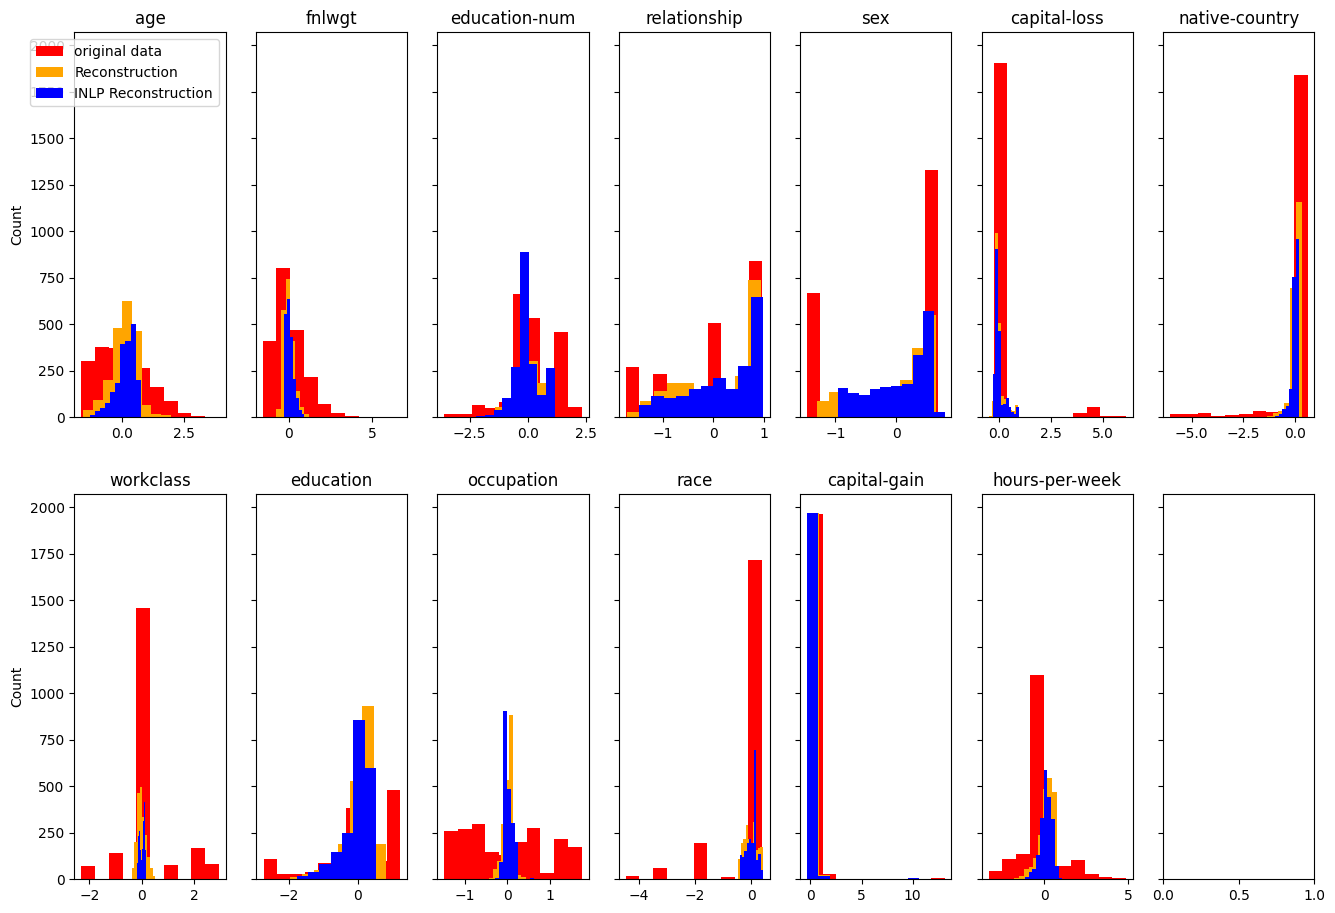

In [ ]:
# Compare reconstructions of features in distriution with original
t=2
fig,plot=plt.subplots(t,len(attributes)//t+1, figsize=(16, 11),sharex=False,sharey=True)
for s in range(len(attributes)):
  plot[s%t,s//t].hist(X_test[attributes[s]], color='red',label='original data')
  plot[s%t,s//t].hist(reconstructed_X_test[:,s],color='orange', label= 'Reconstruction')
  plot[s%t,s//t].hist(reconstructed_X_test_inlp[:,s],color='blue', label='INLP Reconstruction')
  plot[s%t,s//t].set_title(attributes[s])
  if s==0:
    plot[s//t,s%t].legend()
  if s%t==2:
    plot[s%t,s//t].set_xlabel('Value')
  if s//t==0:
    plot[s%t,s//t].set_ylabel('Count')
plt.savefig(f'reconstruction_comparison_{name}.png')
plt.show()

['capital-gain' 'capital-loss' 'occupation' 'race' 'workclass'
 'education-num' 'sex' 'native-country' 'education' 'relationship'
 'fnlwgt']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_124 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6574 - loss: 0.5999 - val_accuracy: 0.8100 - val_loss: 0.4064
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8083 - loss: 0.4259 - val_accuracy: 0.8325 - val_loss: 0.3785
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8189 - loss: 0.3869 - val_accuracy: 0.8325 - val_loss: 0.3641
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8297 - loss: 0.3807 - val_accuracy: 0.8381 - val_loss: 0.3580
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8338 - loss: 0.3673 - val_accuracy: 0.8400 - val_loss: 0.3532
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8437 - loss: 0.3689 - val_accuracy: 0.8369 - val_loss: 0.3519
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8350 - loss: 0.3586 - val_accuracy: 0.8406 - val_loss: 0.3501
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.3642 - val_accuracy: 0.

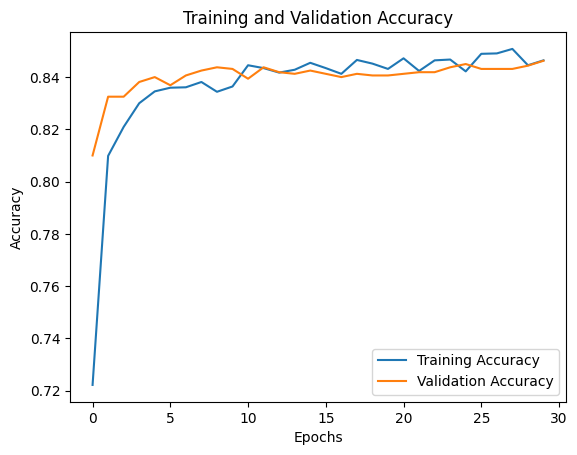

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.8305

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1512
           1       0.70      0.53      0.60       488

    accuracy                           0.83      2000
   macro avg       0.78      0.73      0.75      2000
weighted avg       0.82      0.83      0.82      2000



'\nelse:\n  X_rem=X_train[np.argsort(rec_diff)[:-2]]\n  X_test_rem=X_test[np.argsort(rec_diff)[:-2]]\n  model_test = train_model(X_rem, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)\n  evaluate_model(model_test, X_test_rem,y_test)\n'

In [ ]:
print(attributes[np.argsort(rec_diff)[:-2]])
X_rem=X_train[attributes[np.argsort(rec_diff)[:-1]]]
X_test_rem=X_test[attributes[np.argsort(np.array(rec_diff))][:-1]]
model_test = train_model(X_rem, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)
evaluate_model(model_test, X_test_rem,y_test)


In [ ]:
encoded_data_rem = get_encoder_output(model_test)
encoder = get_encoder(get_encoder_input(model_test), encoded_data_rem)
encoder_outputs_rem= encoder.predict(X_rem)
encoder_outputs_rem_test= encoder.predict(X_test_rem)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
print(f"Accuracy of predicting a from X: {log.score(X_test, protected_attribute_test)}")
#Check if the protected attribute is predicatble from reconstructed data
reconstructed_X_train = decoder_trained.predict(encoder_outputs_train)
linearmodel2 = LogisticRegression()
linearmodel2.fit(reconstructed_X_train, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed: {linearmodel2.score(reconstructed_X_test, protected_attribute_test)}")

#Check if the protected attribute is predicatble from reconstructed data with INLP
reconstructed_X_train_inlp = decoder_trained.predict(X_projected_train)
linearmodel3 = LogisticRegression()
linearmodel3.fit(reconstructed_X_train_inlp, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed_INLP: {linearmodel3.score(reconstructed_X_test_inlp, protected_attribute_test)}")

#Check if the protected attribute is predicatble from reconstructed data
reconstructed_X_train = decoder_trained.predict(encoder_outputs_rem)
reconstructed_X_test = decoder_trained.predict(encoder_outputs_rem_test)
linearmodel2 = LogisticRegression()
linearmodel2.fit(reconstructed_X_train, protected_attribute_train)
print(f"Accuracy of predicting a from X_reconstructed without having relationship in training: {linearmodel2.score(reconstructed_X_test, protected_attribute_test)}")


#Majority vote ratio
print("Majority vote result:", abs((protected_attribute_test.sum()-len(protected_attribute_test))/len(protected_attribute_test)))

Accuracy of predicting a from X: 0.979
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of predicting a from X_reconstructed: 0.8665
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy of predicting a from X_reconstructed_INLP: 0.815
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy of predicting a from X_reconstructed without having relationship in training: 0.8385
Majority vote result: 0.5145


# Data modification as identification tool

In [ ]:
def train_model_Pope(X_with_a, X, a, output_space, orgmodel, epochs=20, batch_size=64, val_split=0.2, lc=0.5, lr=0.2):

    class CustomLoss(tf.keras.losses.Loss):
        def __init__(self, lr, lc, a, orgmodel, **kwargs):
            super().__init__(**kwargs)
            self.lr = lr
            self.lc = lc
            self.orgmodel= orgmodel
            self.a = tf.cast(a, tf.float32)

        def call(self, y_true, y_pred):
            @tf.function(input_signature=[tf.TensorSpec(shape=y_pred.shape, dtype=y_pred.dtype)])
            def predict_ys(y_pred):
                return self.orgmodel(y_pred)

            ys = predict_ys(y_true)
            ys_pred = predict_ys(y_pred)
            recon_loss = tf.reduce_mean(tf.square(y_pred - y_true))

            # Independence measure via correlation (approximation)
            corr = tf.reduce_mean(((ys_pred - tf.reduce_mean(ys_pred))/tf.math.reduce_std(ys_pred)) *
                                 ((self.a - tf.reduce_mean(self.a))/tf.math.reduce_std(self.a)))
            independence_loss = tf.square(corr)
            acc_loss = tf.reduce_mean(tf.square(ys_pred - ys))
            return acc_loss + self.lr * recon_loss + self.lc * independence_loss

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(output_space*4, activation='relu', input_shape=(X_with_a.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_space*2, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(output_space, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss=CustomLoss(lr=lr, lc=lc, a=a, orgmodel=orgmodel),
        metrics=['accuracy']
    )

    history = model.fit(
        X_with_a, X,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=val_split,
        verbose=1,
    )

  # Plot training history (optional)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6194 - loss: 0.6163 - val_accuracy: 0.9200 - val_loss: 0.2334
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9172 - loss: 0.2173 - val_accuracy: 0.9400 - val_loss: 0.1422
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9400 - loss: 0.1441 - val_accuracy: 0.9400 - val_loss: 0.1407
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9424 - loss: 0.1340 - val_accuracy: 0.9400 - val_loss: 0.1402
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9419 - loss: 0.1305 - val_accuracy: 0.9400 - val_loss: 0.1399
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9426 - loss: 0.1310 - val_accuracy: 0.9400 - val_loss: 0.1400
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9426 - loss: 0.1299 - val_accuracy: 0.9400 - val_loss: 0.1400
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9421 - loss: 0.1292 - val_accuracy: 0

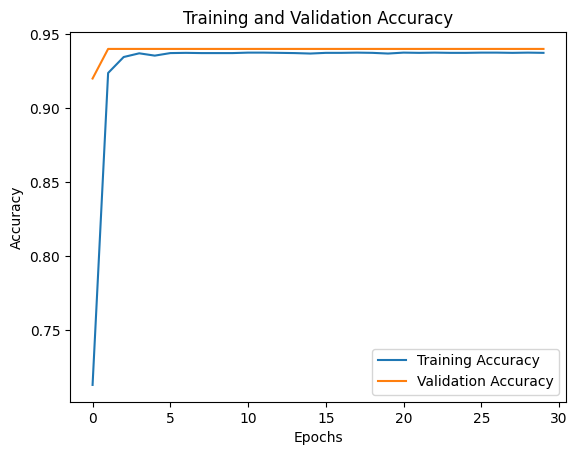

In [ ]:
latent_space=8
orgmodel = train_model(X_train, y_train, epochs=30, batch_size=64, val_split=0.2, latent_space=latent_space)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3828 - loss: 0.6225 - val_accuracy: 0.4925 - val_loss: 0.6018
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4368 - loss: 0.5749 - val_accuracy: 0.4875 - val_loss: 0.5521
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4978 - loss: 0.5187 - val_accuracy: 0.5775 - val_loss: 0.2614
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5215 - loss: 0.2827 - val_accuracy: 0.5975 - val_loss: 0.2439
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5229 - loss: 0.2597 - val_accuracy: 0.5456 - val_loss: 0.2403
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5171 - loss: 0.2510 - val_accuracy: 0.5550 - val_loss: 0.2382
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5275 - loss: 0.2449 - val_accuracy: 0.5512 - val_loss: 0.2353
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5114 - loss: 0.2412 - val_accuracy: 0

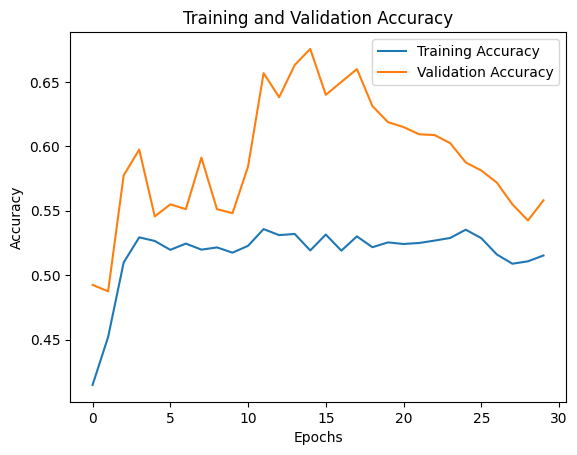

In [ ]:
input_shape= get_encoder_input(orgmodel).shape[1]
a=np.array(protected_attribute_train)
X_with_a= np.concatenate((X_train,a.reshape(-1,1)),axis=1)
datamodel= train_model_Pope(X_with_a, X_train, a, input_shape, orgmodel, epochs=30)

In [ ]:
a_test=np.array(protected_attribute_test)
test_pred=datamodel.predict(np.concatenate((X_test,a_test.reshape(-1,1)),axis=1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
for x in range(len(attributes)):
  print( f"{attributes[np.argsort(-np.mean(np.square(test_pred-X_test),axis=0))][x]} differs from original by {-np.sort(-np.mean(np.square(test_pred-X_test),axis=0))[x]:.3f}")


randomfeature5 differs from original by 0.818
randomfeature4 differs from original by 0.806
corrfeature3 differs from original by 0.802
compproxfeature1 differs from original by 0.747
compproxfeature2 differs from original by 0.745


#Anomaly Detection


In [ ]:
#data preparation:
X = ndf.drop(columns=[target])
y = ndf[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
scaler=StandardScaler()
latent_space=8

#Store sensitive attribute and remove it from data set
y2 = X_train[sens_attr]
X_train=X_train.drop(columns=[sens_attr])
y2_test = X_test[sens_attr]
X_test=X_test.drop(columns=[sens_attr])

if np.sum(y2==0) > np.sum(y2==1):
  y2.loc[y2==1]=2
  y2.loc[y2==0]=1
  y2_test.loc[y2_test==1]=2
  y2_test.loc[y2_test==0]=1
else:
  y2.loc[y2==1]=1
  y2.loc[y2==0]=2
  y2_test.loc[y2_test==1]=1
  y2_test.loc[y2_test==0]=2

# Normalize data
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6783 - loss: 0.6200 - val_accuracy: 0.9133 - val_loss: 0.2183
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9105 - loss: 0.2327 - val_accuracy: 0.9354 - val_loss: 0.1449
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9364 - loss: 0.1550 - val_accuracy: 0.9354 - val_loss: 0.1403
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9432 - loss: 0.1378 - val_accuracy: 0.9354 - val_loss: 0.1396
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9444 - loss: 0.1381 - val_accuracy: 0.9354 - val_loss: 0.1397
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9436 - loss: 0.1339 - val_accuracy: 0.9354 - val_loss: 0.1393
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9442 - loss: 0.1311 - val_accuracy: 0.9354 - val_loss: 0.1392
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9439 - loss: 0.1322 - val_accuracy: 0.9354 - val_loss

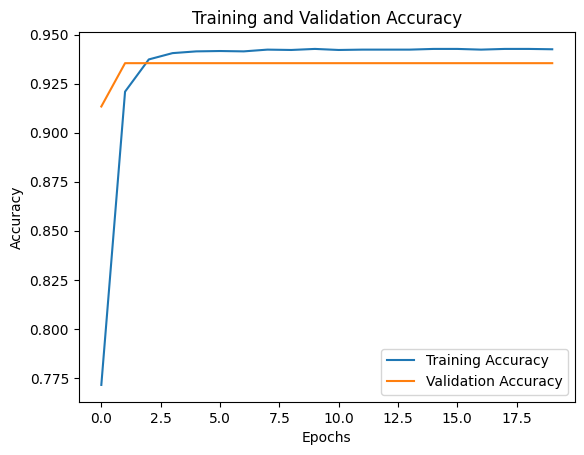

In [ ]:
#encoder_model:
ad_model = train_model(X_train, y_train, epochs=20, batch_size=64, val_split=0.3, latent_space=latent_space)


In [ ]:
ad_encoded_data = get_encoder_output(ad_model)
ad_encoder = get_encoder(get_encoder_input(ad_model), ad_encoded_data)


# Get the outputof last layer as a NumPy array
encoded_X_train = ad_encoder.predict(X_train)
encoded_X_test = ad_encoder.predict(X_test)

#split encoded data in normal and anomal data
normals_train = encoded_X_train[y2==1]
anomalies_train = encoded_X_train[y2==2]

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
def orthogonal_projection_constraint(W_e, W_d, X):
    """ Compute the orthogonality constraint loss """
    X_T = tf.transpose(X)
    P_H1 = tf.matmul(X_T,tf.linalg.pinv(X_T))  # Projection operator
    P_approx = tf.matmul(W_e, W_d, transpose_a=True, transpose_b=True)  # Approximate projection operator
    return tf.norm(P_approx - P_H1)**2

class Autoencoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Dense(latent_dim, use_bias=False)
        self.decoder = Dense(input_dim, use_bias=False)

    def call(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

def train_step(X_train, enc_X_train, decmodel):
    with tf.GradientTape() as tape:
        enc_X_reconstructed, Z = autoencoder(enc_X_train)
        pred_X = decmodel(enc_X_reconstructed)

        # Compute loss terms
        projection_loss = loss_fn(enc_X_train, enc_X_reconstructed)
        reconstruction_loss = loss_fn(X_train, pred_X)
        opc_loss = orthogonal_projection_constraint(autoencoder.encoder.weights[0],
                                                   autoencoder.decoder.weights[0], enc_X_train)

        loss = reconstruction_loss + lambda1 * projection_loss + lambda2 * opc_loss

    gradients = tape.gradient(loss, autoencoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
    return projection_loss,opc_loss,loss

In [ ]:
# Hyperparameters
input_dim = encoded_X_train.shape[-1]  # Example input dimension
latent_dim = latent_space  # Latent space dimension
learning_rate = 0.01
lambda1 = 0.1
lambda2 = 0.4

# Initialize model, loss, optimizer
autoencoder = Autoencoder(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.9117 - val_loss: 0.8016
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9412 - val_loss: 0.7312
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8401 - val_loss: 0.7087
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7856 - val_loss: 0.6805
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7449 - val_loss: 0.6535
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7112 - val_loss: 0.6203
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6763 - val_loss: 0.5788
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6420 - val_loss: 0.5443
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6073 - val_loss: 0.5076
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5810 - val_loss: 0.4923
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5651 - val_loss: 0.4870
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5459 - val_l

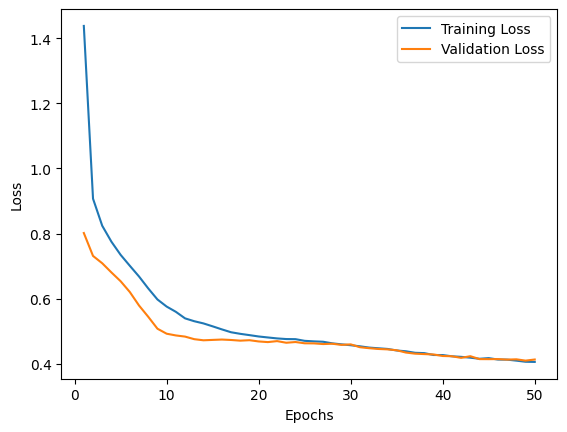

In [ ]:
decmodel = train_decoder(X_train, encoded_X_train, epochs=50, batch_size=256, val_split=0.2)

In [ ]:
# Training Loop
epochs = 25
batch_size = 256

x_train = normals_train
x_test = encoded_X_test

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Shuffle training data for each epoch
    idx = np.random.permutation(len(x_train))
    x_train = encoded_X_train[idx]

    # Iterate through batches
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Run a training step
        proj_loss, opc_loss, total_loss = train_step(X_train[y2==1],x_train, decmodel)
    #Print intermediate results
    print(f" \q Projection loss: {proj_loss.numpy():.3f}, OPC_loss: {opc_loss.numpy():.3f}, Total Loss = {total_loss.numpy():.3f}")


Epoch 1/25
 \q Projection loss: 18.400, OPC_loss: 4.674, Total Loss = 5.373
Epoch 2/25
 \q Projection loss: 12.962, OPC_loss: 2.989, Total Loss = 3.837
Epoch 3/25
 \q Projection loss: 9.174, OPC_loss: 2.228, Total Loss = 3.144
Epoch 4/25
 \q Projection loss: 6.265, OPC_loss: 1.823, Total Loss = 2.673
Epoch 5/25
 \q Projection loss: 4.076, OPC_loss: 1.508, Total Loss = 2.327
Epoch 6/25
 \q Projection loss: 3.075, OPC_loss: 1.292, Total Loss = 2.135
Epoch 7/25
 \q Projection loss: 2.751, OPC_loss: 1.074, Total Loss = 2.007
Epoch 8/25
 \q Projection loss: 2.607, OPC_loss: 0.855, Total Loss = 1.916
Epoch 9/25
 \q Projection loss: 2.501, OPC_loss: 0.651, Total Loss = 1.818
Epoch 10/25
 \q Projection loss: 2.424, OPC_loss: 0.474, Total Loss = 1.741
Epoch 11/25
 \q Projection loss: 2.372, OPC_loss: 0.348, Total Loss = 1.681
Epoch 12/25
 \q Projection loss: 1.818, OPC_loss: 0.243, Total Loss = 1.582
Epoch 13/25
 \q Projection loss: 0.431, OPC_loss: 0.106, Total Loss = 1.311
Epoch 14/25
 \q Pro

In [ ]:
# After training, you can evaluate the model or detect anomalies similarly as before
reconstructed_test, Z = autoencoder.predict(x_test)
reconstructed_train, Z = autoencoder.predict(x_train)
mse_loss_datawise = np.mean(np.square(x_test - reconstructed_test), axis=1)
mse_loss_featurewise = np.mean(np.square(x_test - reconstructed_test), axis=0)

# Detect anomalies based on a threshold
threshold = np.percentile(mse_loss_datawise, 95)  # Example: top 5% of MSE values as anomalies
anomalies = mse_loss_datawise > threshold


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
#check if the neurons changed the most are actually important for the model
last_weights=ad_model.layers[-1].weights[0].value.numpy()
lw=(last_weights[np.argsort(-mse_loss_featurewise)]).flatten()

print("Neuron weights, change strength",np.round(np.stack((lw,np.sort(-mse_loss_featurewise)),axis=1),3))


Neuron weights, change strength [[-0.468 -0.384]
 [-0.44  -0.243]
 [ 0.275 -0.232]
 [ 0.243 -0.212]
 [-1.    -0.172]
 [ 0.213 -0.144]
 [ 0.776 -0.128]
 [-0.654 -0.042]]


In [ ]:
print("Anomalies detected:", ( mse_loss_datawise >( np.mean(mse_loss_datawise)+2*np.std(mse_loss_datawise))).sum())
print(f"Anomlies existing: {x_test[y2_test==2].shape[0]}")

print("Anomalies detected:", (mse_loss_datawise < ( np.mean(mse_loss_datawise)-2*np.std(mse_loss_datawise))).sum())
print(f"Anomlies existing: {x_test[y2_test==2].shape[0]}")

print(f"Mean, Std MSE anomal data. {np.mean(mse_loss_datawise[y2_test==2]):.3f}, {np.std(mse_loss_datawise[y2_test==2]):.3f}")
print(f"Mean, Std MSE normal data. {np.mean(mse_loss_datawise[y2_test==1]):.3f}, {np.std(mse_loss_datawise[y2_test==1]):.3f}")
print(f"Featurewise MSE loss: {[f'{x}: {y:.3f}' for x, y in zip(attributes, mse_loss_featurewise)]}")


Anomalies detected: 65
Anomlies existing: 1006
Anomalies detected: 0
Anomlies existing: 1006
Mean, Std MSE anomal data. 0.256, 0.051
Mean, Std MSE normal data. 0.133, 0.026
Featurewise MSE loss: ['compproxfeature1: 0.144', 'compproxfeature2: 0.172', 'corrfeature3: 0.128', 'randomfeature4: 0.212', 'randomfeature5: 0.042']


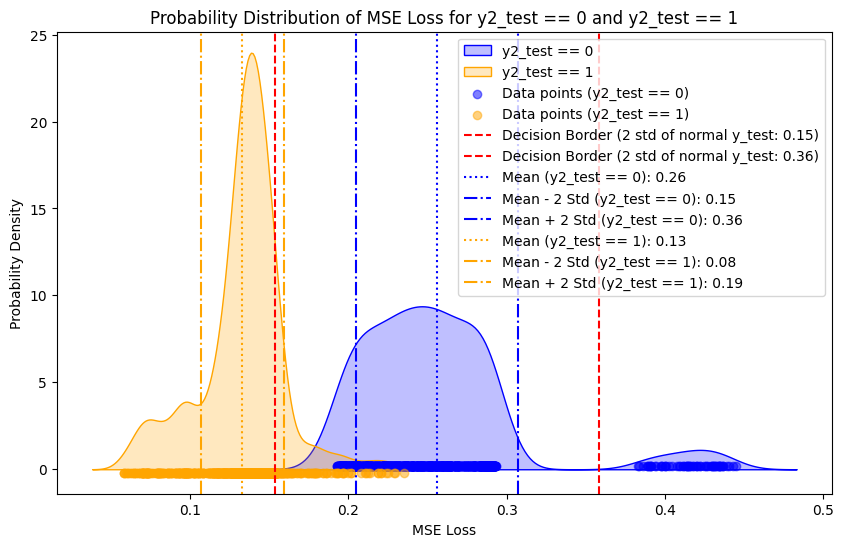

In [ ]:
# Create a KDE for each class
kde_0 = gaussian_kde(mse_loss_datawise[y2_test == 2])
kde_1 = gaussian_kde(mse_loss_datawise[y2_test == 1])

# Create a range of values for the x-axis
x_values = np.linspace(min(mse_loss_datawise), max(mse_loss_datawise), 1000)

# Calculate the KDE values for each class
kde_values_0 = kde_0(x_values)
kde_values_1 = kde_1(x_values)

# Calculate mean and std for both distributions
mean_0, std_0 = np.mean(mse_loss_datawise[y2_test == 2]), np.std(mse_loss_datawise[y2_test == 2])
mean_1, std_1 = np.mean(mse_loss_datawise[y2_test == 1]), np.std(mse_loss_datawise[y2_test == 1])

# Plot the KDEs
plt.figure(figsize=(10, 6))
sns.kdeplot(mse_loss_datawise[y2_test == 2], label='y2_test == 0', fill=True, color='blue')
sns.kdeplot(mse_loss_datawise[y2_test == 1], label='y2_test == 1', fill=True, color='orange')

# Plot individual data points
plt.scatter(mse_loss_datawise[y2_test == 2], np.zeros_like(mse_loss_datawise[y2_test == 2]) + 0.2, color='blue', alpha=0.5, label='Data points (y2_test == 0)')
plt.scatter(mse_loss_datawise[y2_test == 1], np.zeros_like(mse_loss_datawise[y2_test == 1]) - 0.2, color='orange', alpha=0.5, label='Data points (y2_test == 1)')

# Calculate the decision border (2 std of mse_loss for y2_test == 0)
decision_border0 = mean_0 + 2 * std_0
decision_border2 = mean_0 - 2 * std_0

# Plot the decision border
plt.axvline(x=decision_border2, color='red', linestyle='--', label=f'Decision Border (2 std of normal y_test: {decision_border2:.2f})')
plt.axvline(x=decision_border0, color='red', linestyle='--', label=f'Decision Border (2 std of normal y_test: {decision_border0:.2f})')

# Plot mean and std lines for y2_test == 0
plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean (y2_test == 0): {mean_0:.2f}')
plt.axvline(x=mean_0 - std_0, color='blue', linestyle='-.', label=f'Mean - 2 Std (y2_test == 0): {mean_0 - 2*std_0:.2f}')
plt.axvline(x=mean_0 + std_0, color='blue', linestyle='-.', label=f'Mean + 2 Std (y2_test == 0): {mean_0 + 2*std_0:.2f}')

# Plot mean and std lines for y2_test == 1
plt.axvline(x=mean_1, color='orange', linestyle=':', label=f'Mean (y2_test == 1): {mean_1:.2f}')
plt.axvline(x=mean_1 - std_1, color='orange', linestyle='-.', label=f'Mean - 2 Std (y2_test == 1): {mean_1 - 2*std_1:.2f}')
plt.axvline(x=mean_1 + std_1, color='orange', linestyle='-.', label=f'Mean + 2 Std (y2_test == 1): {mean_1 + 2*std_1:.2f}')

# Add labels and legend
plt.xlabel('MSE Loss')
plt.ylabel('Probability Density')
plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
plt.legend(loc='upper right')

# Show the plot
plt.show()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 1.7801 - val_loss: 1.0529
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0923 - val_loss: 1.0475
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0580 - val_loss: 1.0431
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0529 - val_loss: 1.0441
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0411 - val_loss: 1.0457
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0418 - val_loss: 1.0430
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0385 - val_loss: 1.0424
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0356 - val_loss: 1.0430
Epoch 9/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0342 - val_loss: 1.0413
Epoch 10/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0333 - val_loss: 1.0422
Epoch 11/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0294 - val_loss: 1.0409
Epoch 12/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0346 - val_l

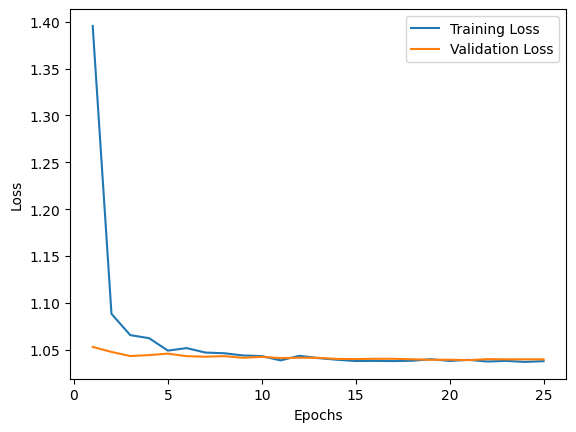

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
decoder_ad=train_decoder(X_train[y2==1],reconstructed_train, epochs=25, val_split=0.2)
reconstructed_X_test_ad = decoder_ad.predict(reconstructed_test)


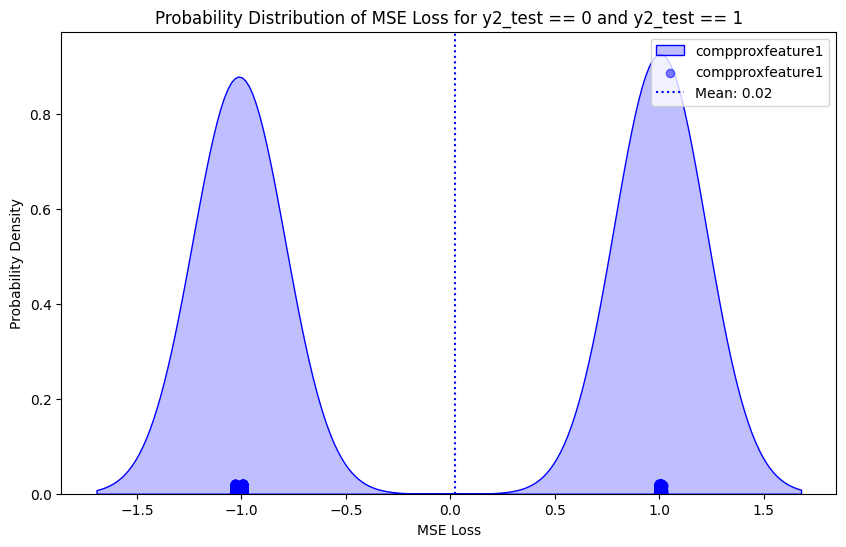

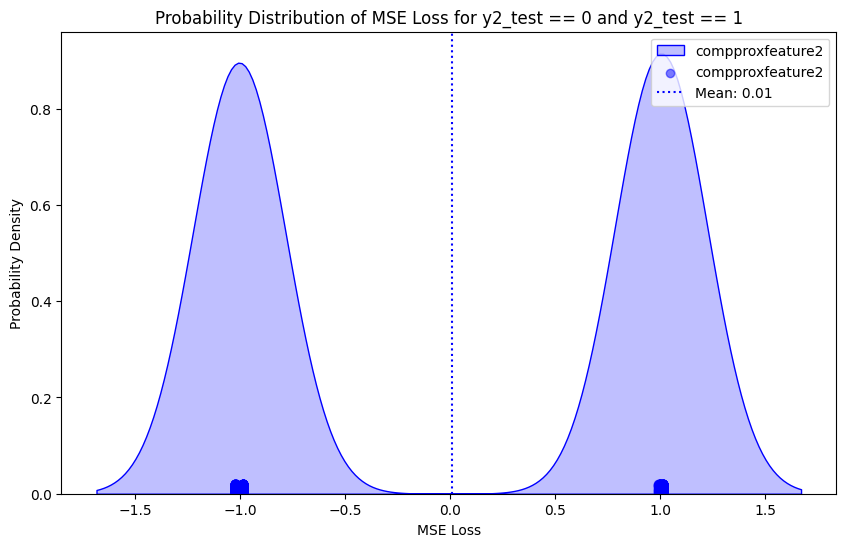

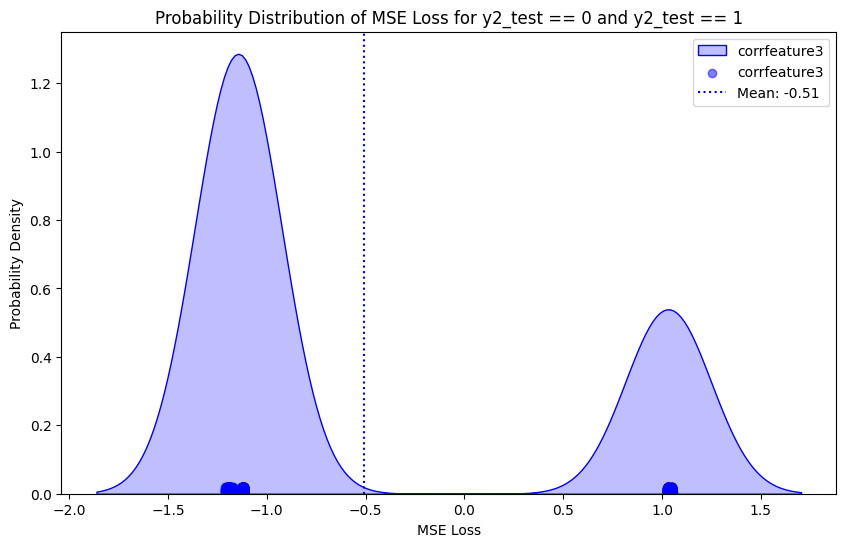

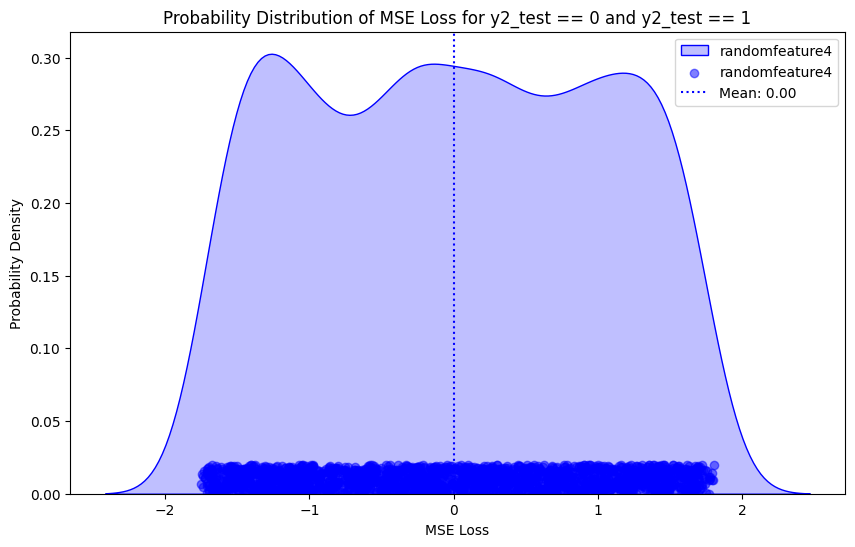

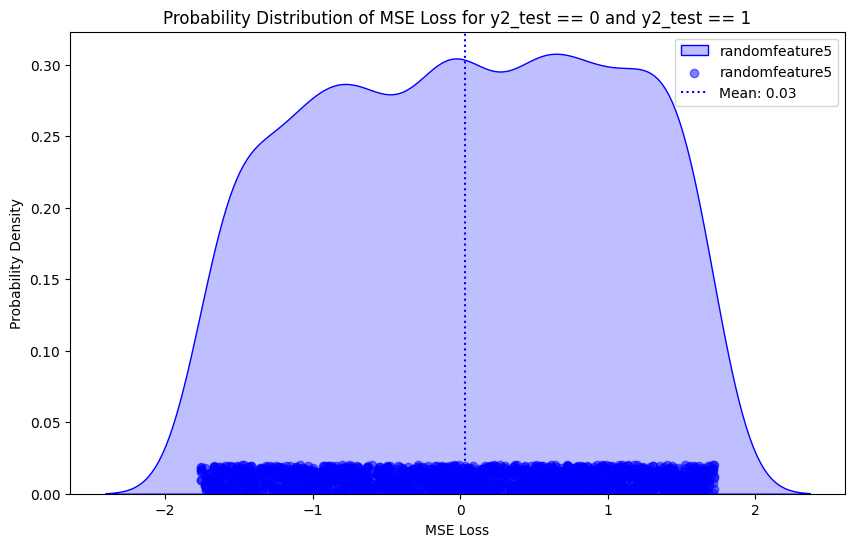

In [ ]:
quad_diffs= (reconstructed_X_test_ad-X_test)
for i in range(X_test.shape[1]):

    #KDEs
    kde_0 = gaussian_kde(quad_diffs[:,i])
    kde_values_0 = kde_0(x_values)

    x_values = np.linspace(np.min(quad_diffs), np.max(quad_diffs), 1000)

    mean_0, std_0 = np.mean(quad_diffs[:,i]), np.std(quad_diffs[:,i])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.kdeplot(quad_diffs[:,i], label=attributes[i], fill=True, color='blue')
    jitter=np.random.random_sample(size=X_test.shape[0])*0.02
    plt.scatter(quad_diffs[:,i], np.zeros_like(quad_diffs[:,i]) + jitter, color='blue', alpha=0.5, label=attributes[i])
    plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean: {mean_0:.2f}')

    plt.xlabel('MSE Loss')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
    plt.legend(loc='upper right')

plt.show()

In [ ]:
for x in range(attributes.shape[0]):
  print( f"{attributes[np.argsort(-np.mean(quad_diffs, axis=0))][x]} differs from original by {-np.sort(-np.mean(quad_diffs, axis=0))[x]:.3f}")


randomfeature5 differs from original by 0.034
compproxfeature1 differs from original by 0.021
compproxfeature2 differs from original by 0.009
randomfeature4 differs from original by 0.001
corrfeature3 differs from original by -0.507


# AD baseline

In [ ]:
# Initialize model, loss, optimizer
autoencoder = Autoencoder(input_dim, latent_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
# Training Loop
x_train = encoded_X_train
x_test = encoded_X_test
epochs = 20
batch_size = 256
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    #randomizing
    idx = np.random.permutation(len(x_train))
    x_train = encoded_X_train[idx]

    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i + batch_size]
        batch = tf.convert_to_tensor(batch, dtype=tf.float32)

        # Training step
        proje_loss, opc_loss, total_loss = train_step(X_train,x_train,decmodel)

    print(f"Projection loss: {proj_loss.numpy():.3f}, OPC_loss: {opc_loss.numpy():.4f}, Total Loss = {total_loss.numpy():.4f}")

Epoch 1/20
Projection loss: 0.195, OPC_loss: 3.3342, Total Loss = 4.3336
Epoch 2/20
Projection loss: 0.195, OPC_loss: 1.3921, Total Loss = 2.4527
Epoch 3/20
Projection loss: 0.195, OPC_loss: 0.9052, Total Loss = 2.0187
Epoch 4/20
Projection loss: 0.195, OPC_loss: 0.6746, Total Loss = 1.9296
Epoch 5/20
Projection loss: 0.195, OPC_loss: 0.5726, Total Loss = 1.8866
Epoch 6/20
Projection loss: 0.195, OPC_loss: 0.4890, Total Loss = 1.8394
Epoch 7/20
Projection loss: 0.195, OPC_loss: 0.4040, Total Loss = 1.7950
Epoch 8/20
Projection loss: 0.195, OPC_loss: 0.3206, Total Loss = 1.7657
Epoch 9/20
Projection loss: 0.195, OPC_loss: 0.3124, Total Loss = 1.6738
Epoch 10/20
Projection loss: 0.195, OPC_loss: 0.2167, Total Loss = 1.6264
Epoch 11/20
Projection loss: 0.195, OPC_loss: 0.1508, Total Loss = 1.5794
Epoch 12/20
Projection loss: 0.195, OPC_loss: 0.1100, Total Loss = 1.5646
Epoch 13/20
Projection loss: 0.195, OPC_loss: 0.0831, Total Loss = 1.5446
Epoch 14/20
Projection loss: 0.195, OPC_loss: 0

'\nfor epoch in range(epochs):\n    loss = train_step(encoded_X_train)\n    if epoch % 10 == 0:\n        print(f"Epoch [{epoch}/{epochs}], Loss: {loss.numpy():.4f}")\n'

In [ ]:
reconstructed_test_base, Z = autoencoder.predict(x_test)
reconstructed_train_base, Z = autoencoder.predict(x_train)
mse_loss_datawise_base = np.mean(np.square(x_test - reconstructed_test), axis=1)
mse_loss_featurewise_base = np.mean(np.square(x_test - reconstructed_test), axis=0)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,125 (12.21 KB)

 Trainable params: 3,125 (12.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5665 - val_loss: 1.0037
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0394 - val_loss: 1.0001
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0250 - val_loss: 0.9995
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0172 - val_loss: 0.9974
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0134 - val_loss: 0.9986
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0108 - val_loss: 0.9976
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0101 - val_loss: 0.9976
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0081 - val_loss: 0.9987
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0058 - val_loss: 0.9975
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0070 - val_loss: 0.9976
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0061 - val_loss: 0.9973
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

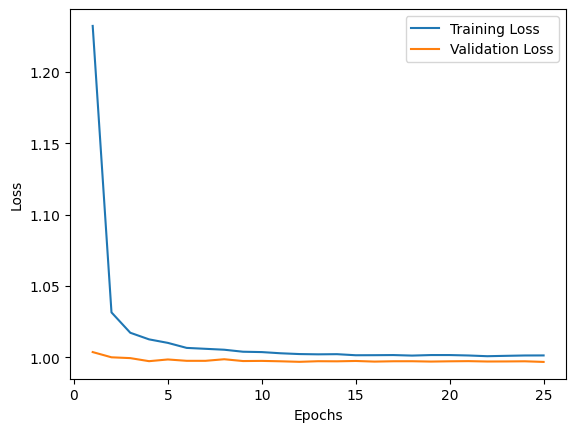

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
decoder_ad_base=train_decoder(X_train,reconstructed_train_base, epochs=25)
reconstructed_X_test_ad_base = decmodel.predict(x_test)
reconstructed_X_test_ad_base2 = decoder_ad_base.predict(reconstructed_test_base)

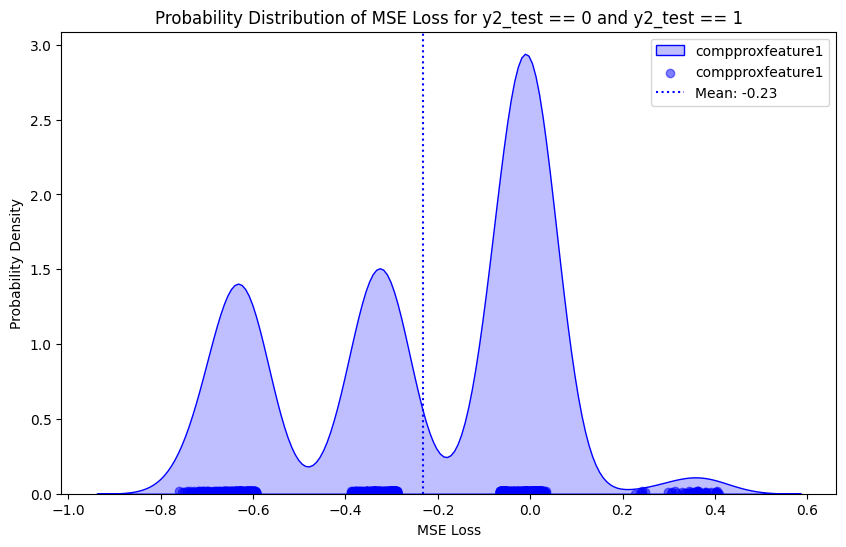

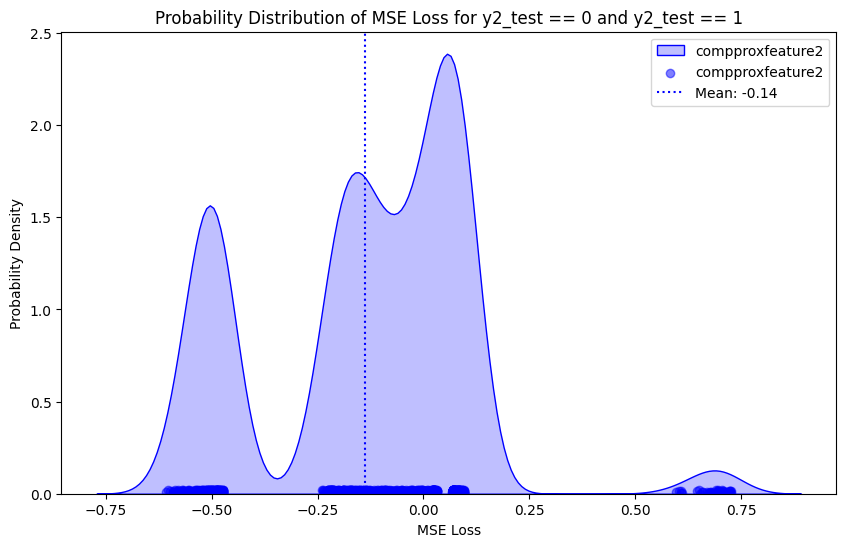

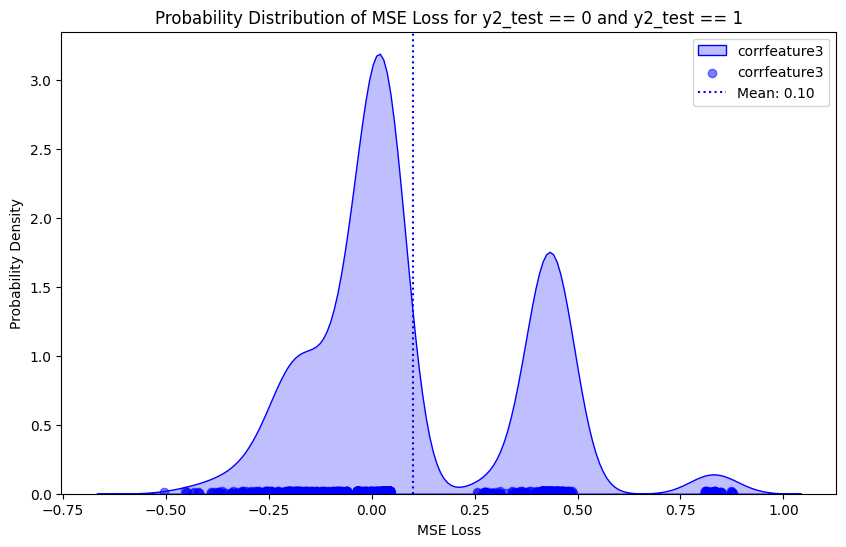

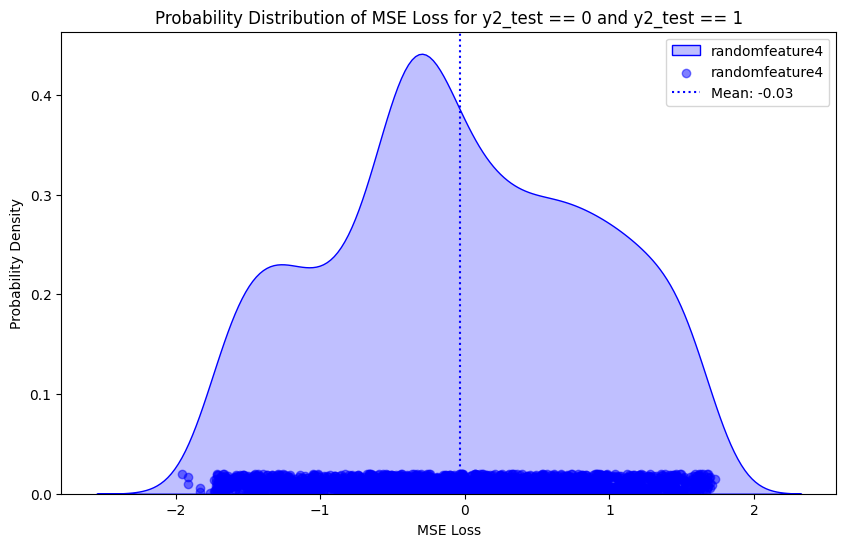

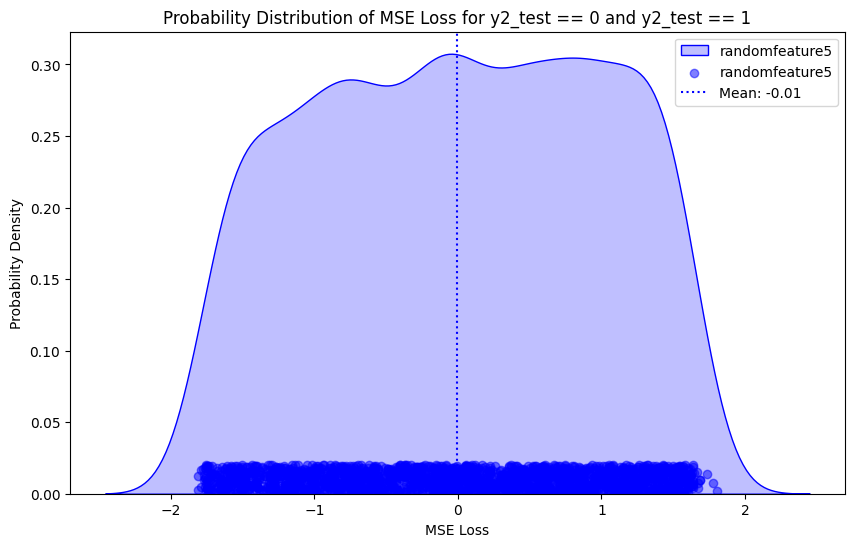

In [ ]:
quad_diffs_base=reconstructed_X_test_ad_base-X_test
for i in range(X_test.shape[1]):

    # Create KDEs
    kde_0 = gaussian_kde(quad_diffs_base[:,i])
    kde_values_0 = kde_0(x_values)

    x_values = np.linspace(np.min(quad_diffs_base), np.max(quad_diffs_base), 1000)


    mean_0, std_0 = np.mean(quad_diffs_base[:,i]), np.std(quad_diffs_base[:,i])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.kdeplot(quad_diffs_base[:,i], label=attributes[i], fill=True, color='blue')

    jitter=np.random.random_sample(size=X_test.shape[0])*0.02
    plt.scatter(quad_diffs_base[:,i], np.zeros_like(quad_diffs_base[:,i]) + jitter, color='blue', alpha=0.5, label=attributes[i])

    plt.axvline(x=mean_0, color='blue', linestyle=':', label=f'Mean: {mean_0:.2f}')

    plt.xlabel('MSE Loss')
    plt.ylabel('Probability Density')
    plt.title('Probability Distribution of MSE Loss for y2_test == 0 and y2_test == 1')
    plt.legend(loc='upper right')

plt.show()

In [ ]:
quad_diffs_base.shape

(2000, 5)

In [ ]:
for x in range(attributes.shape[0]):
  print( f"{attributes[np.argsort(-np.mean(quad_diffs_base, axis=0))][x]} differs from original by {-np.sort(-np.mean(quad_diffs_base, axis=0))[x]:.3f}")



corrfeature3 differs from original by 0.101
randomfeature5 differs from original by -0.007
randomfeature4 differs from original by -0.034
compproxfeature2 differs from original by -0.139
compproxfeature1 differs from original by -0.233


#Comparison baseline vs sensitive AD

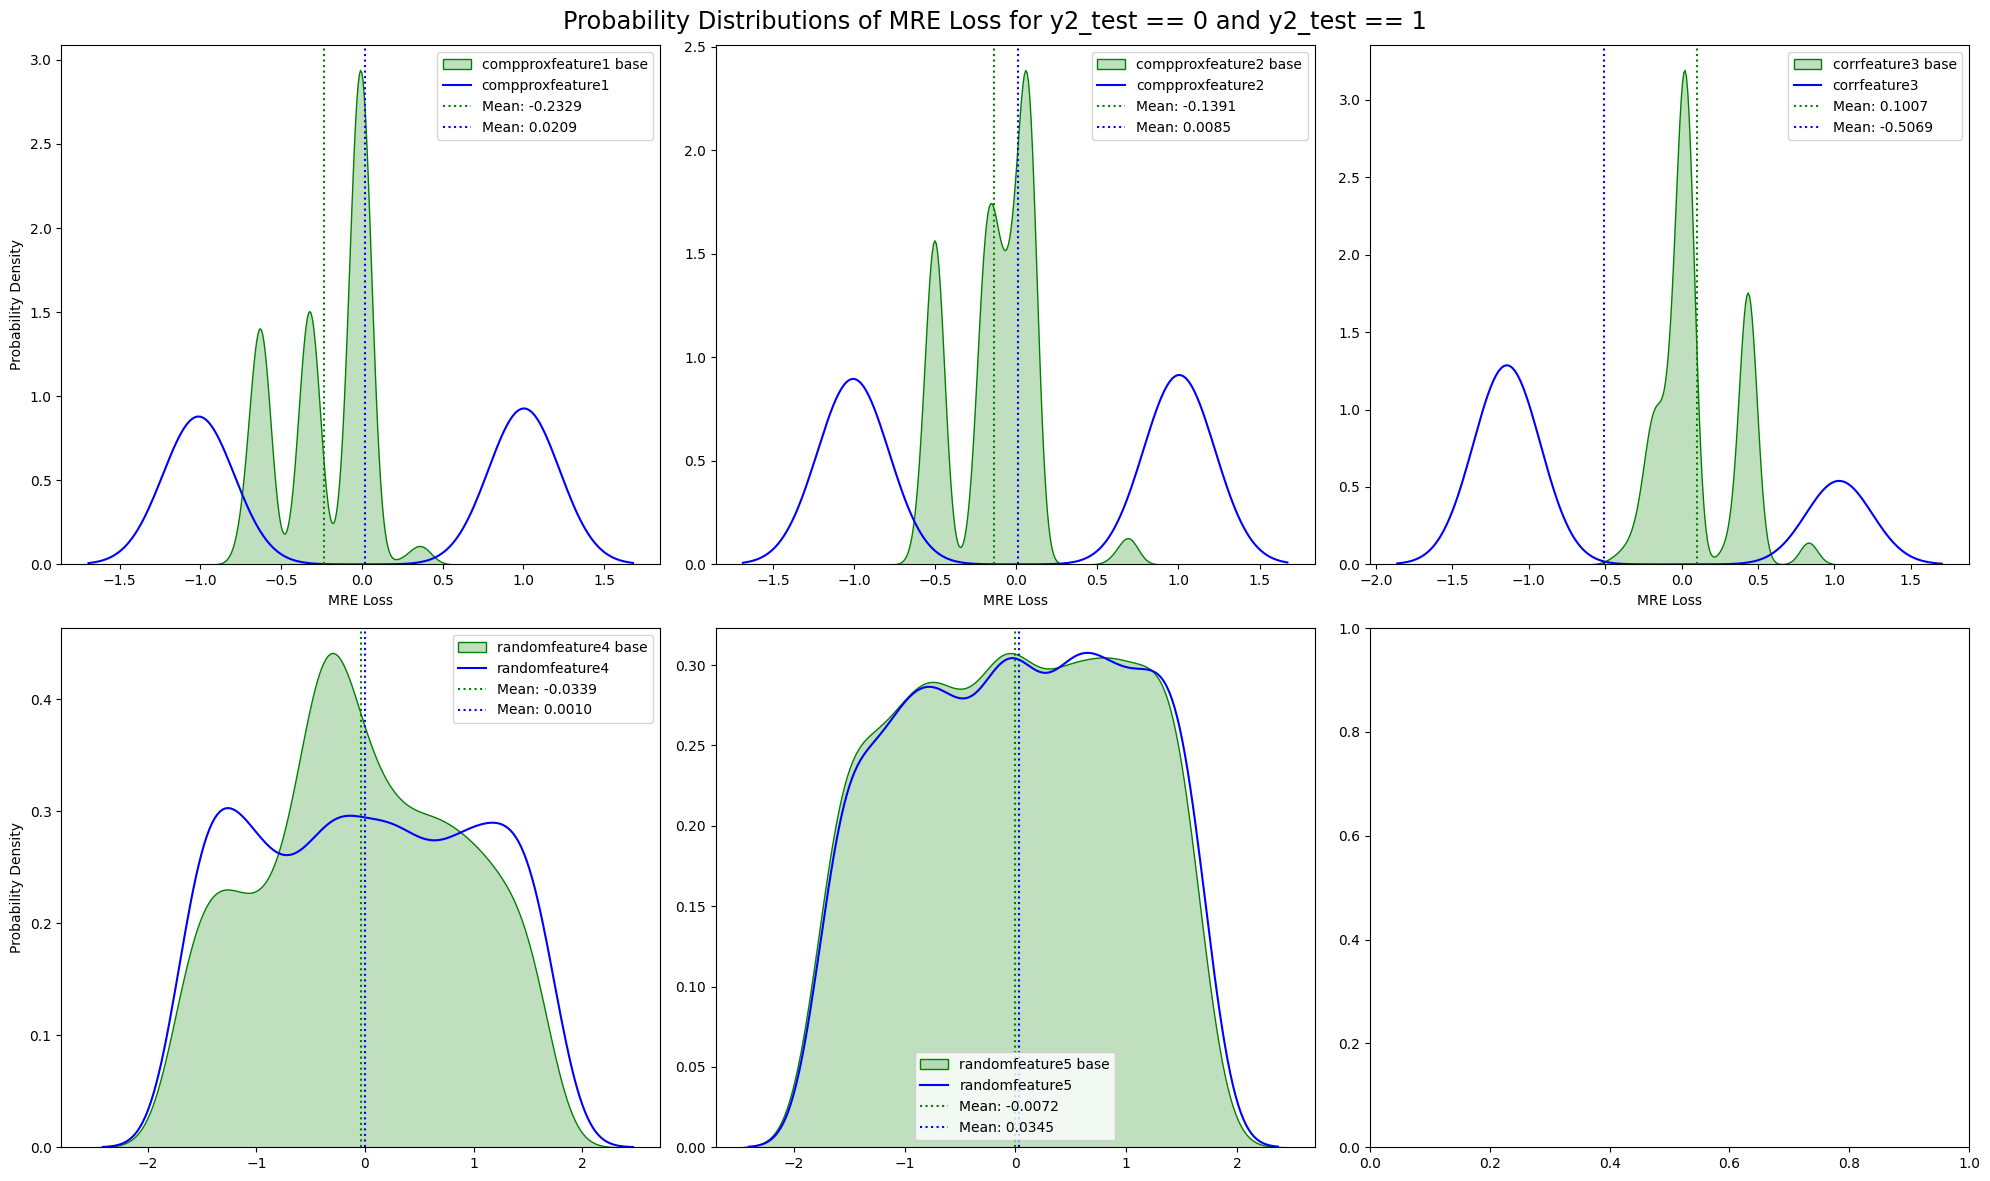

In [ ]:
quad_diffs=quad_diffs
quad_diffs_base=quad_diffs_base
t=3
fig, ax = plt.subplots(len(attributes)//t+1,t, figsize=(20,12))
for i in range(X_test.shape[1]):
    # Create KDEs
    kde_0 = gaussian_kde(quad_diffs_base[:,i])
    kde_2 = gaussian_kde(quad_diffs[:,i])
    kde_values_0 = kde_0(x_values)
    kde_values_2 = kde_2(x_values)

    x_values = np.linspace(np.min((quad_diffs,quad_diffs_base)), np.max((quad_diffs,quad_diffs_base)), 1000)

    mean_0, std_0 = np.mean(quad_diffs_base[:,i]), np.std(quad_diffs_base[:,i])
    mean_2, std_2 = np.mean(quad_diffs[:,i]), np.std(quad_diffs[:,i])

    # Plotting
    sns.kdeplot(quad_diffs_base[:,i], label=f"{attributes[i]} base", ax=ax[i//t,i%t], fill=True, color='green')
    sns.kdeplot(quad_diffs[:,i], label=attributes[i], ax=ax[i//t,i%t], fill=False, color='blue')

    jitter=np.random.random_sample(size=X_test.shape[0])*0.03
    jitter2=np.random.random_sample(size=X_test.shape[0])*0.03

    ax[i//t,i%t].axvline(x=mean_0, color='green', linestyle=':', label=f'Mean: {mean_0:.4f}')
    ax[i//t,i%t].axvline(x=mean_2, color='blue', linestyle=':', label=f'Mean: {mean_2:.4f}')

    if i%t==0:
      ax[i//t,i%t].set_ylabel('Probability Density')
    else:
      ax[i//t,i%t].set_ylabel('')
    if i//t==0:
      ax[i//t,i%t].set_xlabel('MRE Loss')
    ax[i//t,i%t].legend()

fig.suptitle('Probability Distributions of MRE Loss for y2_test == 0 and y2_test == 1',fontsize='xx-large')
fig.tight_layout()
plt.savefig(f'ad_comparison_{name}')
plt.show()

In [ ]:
for x in range(attributes.shape[0]):
  print(f"{attributes[np.argsort(-np.mean(quad_diffs-quad_diffs_base,axis=0))][x]} reconstruction difference is on average: {-np.sort(-np.mean(quad_diffs-quad_diffs_base, axis=0))[x]:.3f}")



compproxfeature1 reconstruction difference is on average: 0.254
compproxfeature2 reconstruction difference is on average: 0.148
randomfeature5 reconstruction difference is on average: 0.042
randomfeature4 reconstruction difference is on average: 0.035
corrfeature3 reconstruction difference is on average: -0.608
